# **Machine Learning methods for fMRI signals - Final project**

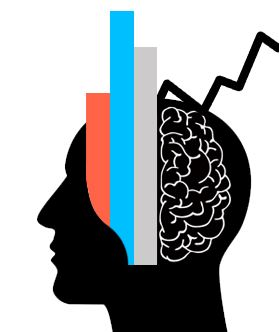




In this project, we're going to take a close look at the information we get from brain scans, known as functional magnetic resonance imaging (fMRI) data. We have data from times when people were watching movies and when they were resting. We're going to use machine learning methods to see if we can predict which movie or rest period a piece of fMRI data is from.

We collected our data from 40 people. Each person watched five different movies and rested for 20 seconds in between each movie.

To refine our analysis, we will focus on data from five specific brain areas, namely:

* Area 11: X_40_DMN_69_IPL (a part of the brain known as the Inferior Parietal

  Lobule within the Default Mode Network)

* Area 1: X_40_Cinop39 (part of the Cingulo-Opercular Network)

* Area 2: X_40_dmn37 (Default Mode Network)

* Area 3: X_40_AUD14 (part of the Auditory Network)

* Area 10: X_40_DMN_41_PCC_R (the Posterior Cingulate Cortex within the Default Mode Network)

The brain data for each subject is stored in a matrix, which keeps track of brain activity over time (number of voxels X time).

# Imports

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import scipy.io
import glob
import os
import numpy as np
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis, LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.metrics import accuracy_score, confusion_matrix, roc_auc_score
import seaborn as sns

import warnings

# ignore all user warnings
warnings.filterwarnings('ignore')


# Loading the files

Load the files.

Note: please decide on the way you want to load the .mat files (drag into google colab / importing from google drive) and use the relevant command line

In [ ]:
# get a list of all .mat files in the current directory that start with 'X_40'

# ==== Upload files from google drive: ====
files = glob.glob('//content//drive//My Drive//FMRI Project//X_40*.mat')

# ==== Upload files by drag into google colab: ====
#files = glob.glob('X_40*.mat')

# create an empty dictionary to hold all the loaded data
data = []

area_names = []

for file in files:
    # load the .mat file
    mat = np.array(list(scipy.io.loadmat(file).items()))
    # area names
    area_names.append(file)
    # add the loaded data to the dictionary, using the filename as the key
    data.append(mat)


In [ ]:
# Get just the filenames without the directory paths
area_names = [os.path.basename(path) for path in area_names]

area_names

['X_40_Cinop39.mat',
 'X_40_AUD14.mat',
 'X_40_DMN_41_PCC_R.mat',
 'X_40_dmn37.mat',
 'X_40_DMN_69_IPL.mat']

# **Part 1**

**Overview of Part 1: Movie Classification based on Functional Connectivity**

In the first section of our project, we are aiming to determine the movie watched by each subject based on their functional brain connectivity data. By utilizing the functional connectivity (FC) matrices, we will employ machine learning techniques to classify the movie corresponding to each FC matrix. Our toolkit of classifiers includes KNN, SVM, LDA, QDA, and Bayes Naïve. To evaluate and compare the performance of these models, we will display the accuracy results using bar plots and compute the Area Under the Curve (AUC) for each classifier.In the end, we will display the confusion matrix for the top three regions with the highest classification accuracy, using only the best-performing classifier.

**Workflow**:

Initially in the first part of our project, where we aimed to classify which movie each participant watched based on functional connectivity matrices from various brain regions, we encountered sub-optimal results. The performance of our classifiers wasn't up to our expectations. To enhance the predictive power of our models, we explored and implemented several techniques:

* Downsampling: Our first approach was to reduce the feature vector volume by lowering the sample rate or resolution, simplifying the data without sacrificing its integrity or inducing significant distortions.

* Principal Component Analysis (PCA): Recognizing the issues associated with high-dimensional data, we used PCA as a dimensionality reduction technique. It transformed the FC matrix data into a new coordinate system of principal components (which are linear combinations of the original variables) that captured the most substantial variances in our data.

* Classifier Tuning: We refined the parameters of our machine learning models, ensuring that they were well-suited to the unique characteristics of our reduced-dimensionality data.

* Cross-Validation: To get a reliable estimate of our model's performance, we utilized k-fold cross-validation, which provides a more robust measure of accuracy compared to traditional train-test splits.

The combination of these strategies led to a marked improvement in the performance of our classifiers, making them more efficient and accurate in predicting the movies watched by the participants. This refined approach set a solid foundation for the next parts of our project.

#Functions:

'extract_sub_matrices' extract the sub matrices which contains the movie/rest (voxel X duration) data.

In [ ]:
def extract_sub_matrices(matrix, start_tr_movie, end_tr_movie, start_tr_rest, end_tr_rest):
    # Initialize an empty dictionary to store the sub-matrices
    sub_matrices = {}

    # Extract the sub-matrices for the movies
    for i in range(len(start_tr_movie)):
        # Subtract 1 from the start and end time points because Python uses 0-based indexing
        start = start_tr_movie[i] - 1
        end = end_tr_movie[i] - 1
        # Extract the sub-matrix
        sub_matrix = matrix[:, start:end+1]
        # Add the sub-matrix to the dictionary
        sub_matrices[f'Movie {i+1}'] = sub_matrix

    return sub_matrices


Downsampling window

In [ ]:
def running_window_on_vector_feature(lower_tri_flat, fc_matrix):
  n = fc_matrix.shape[0]
  offsets = [_ for _ in range(0, lower_tri_flat.shape[0], n//16)]
  downsampled_lower_tri_flat = np.array([np.max(lower_tri_flat[offset:offset+n//16]) for offset in offsets])
  return downsampled_lower_tri_flat

Extract FC matrix and The final feature and apply PCA method on the FC matrix

In [ ]:
def calculate_fc_and_extract_vector_feature(matrix):

    # shape_for_pca = min(matrix.shape[0], matrix.shape[1])

    # # Define the PCA object
    # pca = PCA(n_components=shape_for_pca)  # Adjust n_components as necessary

    # # Apply PCA on the original data
    # transformed_matrix = pca.fit_transform(matrix)

    # # Calculate the correlation matrix
    # fc_matrix = np.corrcoef(transformed_matrix)
    # #print(f"Before PCA \n{fc_matrix}")

    # # Get the indices of the lower triangle
    # lower_tri_indices = np.tril_indices(fc_matrix.shape[0], -1)
    # # Index into the matrix using these indices to get the lower triangle as a flat array
    # lower_tri_flat = fc_matrix[lower_tri_indices]


# Calculate the correlation matrix
    fc_matrix = np.corrcoef(matrix)

    # Store the diagonal elements
    diag_elements = np.diagonal(fc_matrix)

    # Create an array to hold the non-diagonal elements of each row
    non_diag_elements = np.zeros((fc_matrix.shape[0], fc_matrix.shape[1]-1))

    for i in range(fc_matrix.shape[0]):
        non_diag_elements[i] = np.delete(fc_matrix[i], i)

    shape_for_pca = min(non_diag_elements.shape[0], non_diag_elements.shape[1])

    # Apply PCA
    pca = PCA(n_components=shape_for_pca)  # Adjust n_components as necessary
    pca_non_diag_elements = pca.fit_transform(non_diag_elements)

    # Now, reconstruct the diagonal elements into a new square pseudo-correlation matrix
    pseudo_corr_matrix = np.zeros((pca_non_diag_elements.shape[0], pca_non_diag_elements.shape[0]))

    for i in range(pca_non_diag_elements.shape[0]):
        pseudo_corr_matrix[i, :i] = pca_non_diag_elements[i, :i]
        pseudo_corr_matrix[i, i] = diag_elements[i]
        pseudo_corr_matrix[i, i+1:] = pca_non_diag_elements[i, i:]

    # Get the indices of the lower triangle
    lower_tri_indices = np.tril_indices(pseudo_corr_matrix.shape[0], -1)

    # Index into the matrix using these indices to get the lower triangle as a flat array
    lower_tri_flat = pseudo_corr_matrix[lower_tri_indices]

    return lower_tri_flat, pseudo_corr_matrix

Plotting the confusion matrix

In [ ]:
def confusion_matrix_plot(cf_matrix, best_model_name, area_name, best_model_score, labels=None):
    sns.heatmap(cf_matrix, annot=True, cmap='Blues', xticklabels=labels, yticklabels=labels)
    print("\n\n")
    plt.title(f'Confusion Matrix for {best_model_name} in {area_name} with score: {round(best_model_score,2)}')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

# Building the dataset and features

In [ ]:
# Initialize an empty list to store the Series
data_list = []

areas_dataset = []

start_tr_movie = [20,284,525,735,818]
end_tr_movie = [264,505,715,798, 901]
start_tr_rest = [1,265,506,716,799,902]
end_tr_rest = [19,283,524,734,819,921]

# Loop over each brain area
for area in range(len(data)):

    df = pd.DataFrame()

    # Loop over each subject
    for subject in range(len(data[area][3,1])):
        # Get the matrix for the current subject in the current brain area
        matrix = data[area][3,1][subject][0]

        # Separate the data into sub-matrices based on different Movies
        sub_matrices = extract_sub_matrices(matrix, start_tr_movie, end_tr_movie, start_tr_rest, end_tr_rest)

        for movie_number, movie in enumerate(list(sub_matrices.values())):

          # Calculate the lower triangle of the FC matrix as a flat array
          lower_tri_flat, fc_matrix = calculate_fc_and_extract_vector_feature(movie)
          # Reduce feature vector length using DownSampling method
          downsampled_lower_tri_flat = running_window_on_vector_feature(lower_tri_flat, fc_matrix)
          new_row = pd.Series({ 'Lower_Triangle_FC': downsampled_lower_tri_flat, 'Output': movie_number})

          new_row_to_add = new_row.to_frame().T
          df = pd.concat([df, new_row_to_add], ignore_index=True)

    areas_dataset.append((area_names[area], df))


In [ ]:
fc_matrix.shape

(319, 319)

# Prints for testing

In [ ]:
# example for a dataset for area 0 (Cinop39) including our feature and label
print(areas_dataset[0][1])

# example for the shape of a vector that was with length 2080 and after the downsampling it went down to 520
print(areas_dataset[2][1]["Lower_Triangle_FC"][0].shape)

                                     Lower_Triangle_FC Output
0    [2.630286104634961, 3.157179416189717, 3.54167...      0
1    [1.0259928134678256, 0.25826006817793806, 1.14...      1
2    [1.3905062066910878, 1.1983565198003954, 1.102...      2
3    [1.2275369292655363, 0.767187721610127, 1.6220...      3
4    [4.527868393885474, 3.820517993896669, 2.43074...      4
..                                                 ...    ...
195  [3.5256695437394954, 3.087704271075199, 2.3308...      0
196  [1.1199636585344295, 1.3129359763817874, 1.558...      1
197  [0.8668373389832988, 1.0434844222125266, 1.030...      2
198  [2.910050516656675, 2.201657566516162, 3.09481...      3
199  [4.314511739841966, 3.6321354806559563, 3.3907...      4

[200 rows x 2 columns]
(520,)


In [ ]:
fc_matrix.shape

(319, 319)

# Models training, prediction and metrices evaluation:


Results for X_40_Cinop39.mat

    Model Name  AUC Score  Accuracy CV Score  Accuracy Test Score
3          LDA   0.599263             0.2875                0.175
1          SVM   0.593101             0.2625                0.200
2          QDA   0.530809             0.2000                0.275
4  Naive Bayes   0.528800             0.3125                0.150
0          KNN   0.488226             0.1500                0.075

Results for X_40_AUD14.mat

    Model Name  AUC Score  Accuracy CV Score  Accuracy Test Score
1          SVM   0.595606            0.26875                0.150
4  Naive Bayes   0.559187            0.29375                0.200
2          QDA   0.519031            0.19375                0.200
0          KNN   0.485317            0.20625                0.225
3          LDA   0.471341            0.25625                0.175

Results for X_40_DMN_41_PCC_R.mat

    Model Name  AUC Score  Accuracy CV Score  Accuracy Test Score
0          KNN   0.517110            0.15000  

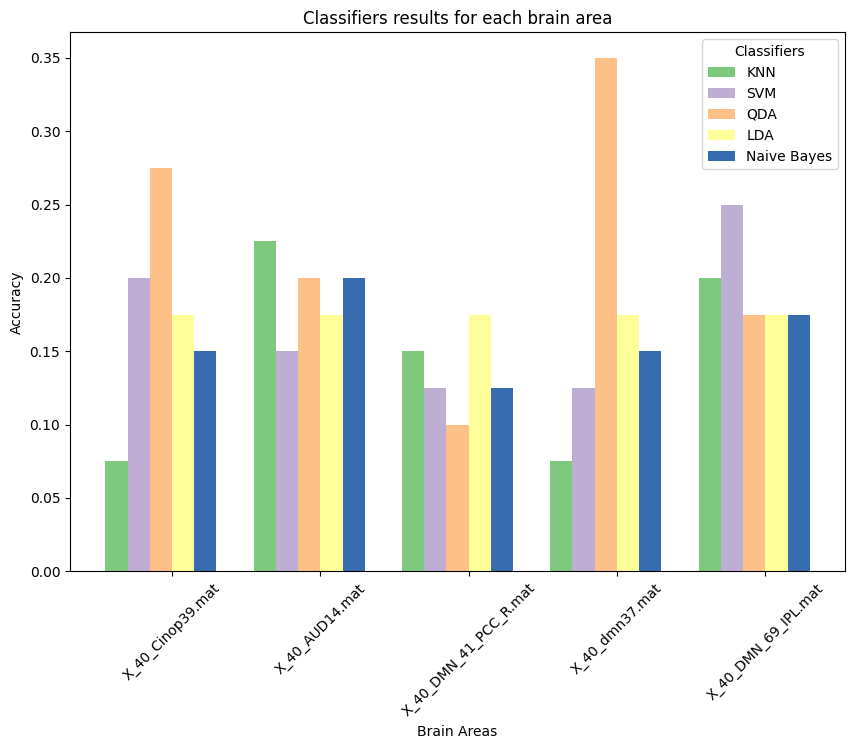

In [ ]:
# Create a list to store the best model's accuracy score and name from each area
best_model_accuracies = []

# Create a list to store the confusion matrices of the best model in each area
confusion_matrices = []

# Create a list to store the accuracy scores for each classifier and area
all_accuracy_scores = []

# List of classifiers
classifiers = ['KNN', 'SVM', 'QDA', 'LDA', 'Naive Bayes']

# Create a list to store the accuracy scores for each classifier in each area
classifier_accuracy_scores = [[] for _ in range(len(classifiers))]

# Iterate over the brain areas
for i in range(len(area_names)):
    # Load data
    df = areas_dataset[i][1].copy()

    result_table = pd.DataFrame(columns=['Model Name', 'AUC Score', 'Accuracy CV Score', 'Accuracy Test Score'])

    # Separate features and target
    X = df['Lower_Triangle_FC'].to_list()
    y = df['Output'].astype('int').values

    # Split the data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Standardize the feature
    scaler = StandardScaler()
    scaler.fit(X_train)

    # Apply transform to both the training set and the test set.
    X_train = scaler.transform(X_train)
    #X_test = scaler.transform(X_test)


    # Define hyperparameters for grid search
    hyperparameters = {
        "KNN": {"n_neighbors": [3, 5, 7, 9, 11]},
        "SVM": {"C": [0.1, 1, 10, 100], "gamma": [1, 0.1, 0.01, 0.001]},
        "QDA": {"reg_param": [0.0, 0.1, 0.2, 0.3, 0.4, 0.5]},
        "LDA": {"solver": ["svd", "lsqr", "eigen"]},
        "Naive Bayes": {}
    }

    # List of models
    models = [
        ("KNN", KNeighborsClassifier()),
        ("SVM", SVC(probability=True)),
        ("QDA", QuadraticDiscriminantAnalysis()),
        ("LDA", LinearDiscriminantAnalysis()),
        ("Naive Bayes",GaussianNB()),
    ]

    # Train and evaluate each model
    model_names = []
    top_models = []

    for name, model in models:
        # Perform grid search to find optimal hyperparameters
        clf = GridSearchCV(model, hyperparameters[name], cv=5)
        clf.fit(X_train, y_train)

        best_model = clf.best_estimator_

        # Apply k-fold Cross Validation
        cv = KFold(n_splits=10, shuffle=False)
        scores = cross_val_score(best_model, X_train, y_train, scoring='accuracy', cv=cv, n_jobs=-1)
        avg_cv_score = np.mean(scores)

        # Predict the labels for the test set
        y_pred = best_model.predict(X_test)

        y_pred_proba = best_model.predict_proba(X_test)
        auc_score = roc_auc_score(y_test, y_pred_proba, multi_class='ovr')

        # Calculate the accuracy on the test set
        test_score = accuracy_score(y_test, y_pred)

        # Store results in the table
        result_table = result_table.append({'Model Name': name,
                                            'AUC Score': auc_score,
                                            'Accuracy CV Score': avg_cv_score,
                                            'Accuracy Test Score': test_score}, ignore_index=True)

        # Store the models and their scores
        top_models.append((name, best_model, avg_cv_score, test_score))
        model_names.append(name)

        # Store the accuracy scores for each classifier in the current area
        classifier_index = classifiers.index(name)
        classifier_accuracy_scores[classifier_index].append(test_score)

    # Sort the result table by AUC score in descending order
    result_table = result_table.sort_values(by='AUC Score', ascending=False)
    # Print the result table
    print(f"\nResults for {area_names[i]}\n")
    print(result_table)


    # Sort models based on their average accuracy score
    top_models.sort(key=lambda x: x[3], reverse=True)

    # Store the best model's accuracy score and name from each area
    best_model_accuracies.append((area_names[i], top_models[0][0], top_models[0][3]))

    # Plot confusion matrix for the best model
    best_model_name, best_model, best_model_cv_score, best_model_test_score = top_models[0]
    y_pred = best_model.predict(X_test)
    cf_matrix = confusion_matrix(y_test, y_pred)

    # Store the confusion matrix of the best model in each area
    confusion_matrices.append((area_names[i], top_models[0][0], cf_matrix))

# Combine the bar plots into one
fig, ax = plt.subplots(figsize=(10, 7))
width = 0.15  # Width of each sub-bar

for i in range(len(classifiers)):
    x = np.arange(len(area_names))
    color = plt.cm.get_cmap('Accent')(i)  # Generate unique color for each classifier

    # Plotting the sub-bars for each brain area
    ax.bar(x + (i * width), classifier_accuracy_scores[i], width=width, color=color, label=classifiers[i])

# Setting up the plot labels and legend
ax.set_xlabel('Brain Areas')
ax.set_ylabel('Accuracy')
ax.set_title('Classifiers results for each brain area')
ax.set_xticks(x + (len(classifiers) / 2 * width))
ax.set_xticklabels(area_names, rotation = 45)
ax.legend(title='Classifiers')

plt.show()


Combine the lists of the accuracies and confusion matrices into one object

In [ ]:
combined_list = [(a[0], a[1], a[2], c[2]) for a, c in zip(best_model_accuracies, confusion_matrices)]

combined_list_sorted = sorted(combined_list, key=lambda x: x[2], reverse=True)

Plot the best 3 areas confusion matrices

Confusion matrices based on the best model accuracy in the top 3 areas with best accuracy score:





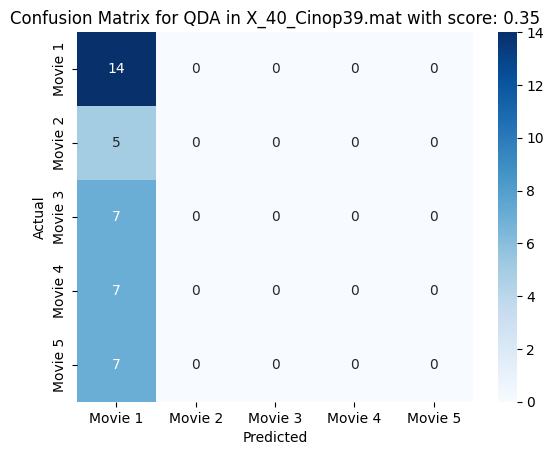

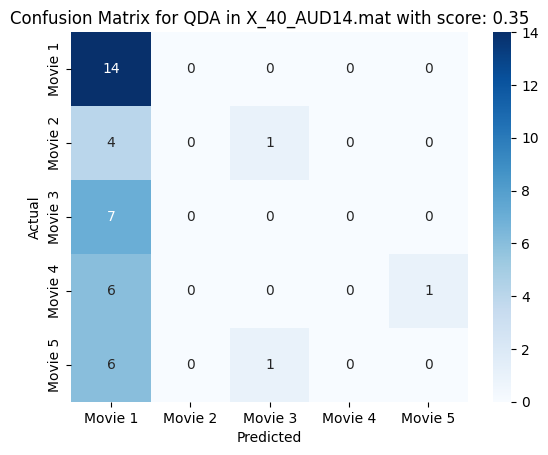

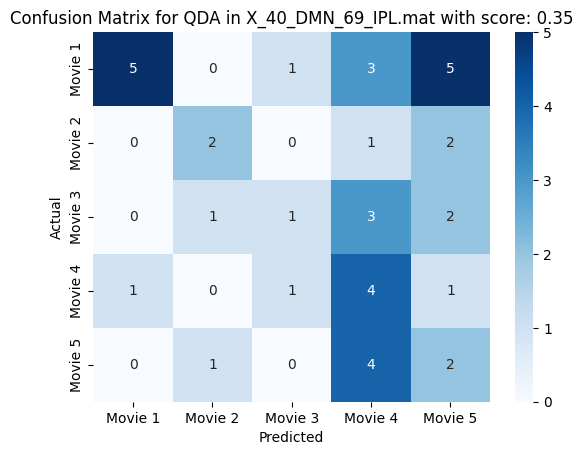

In [ ]:
print("Confusion matrices based on the best model accuracy in the top 3 areas with best accuracy score:")
labels = ['Movie 1', 'Movie 2', 'Movie 3', 'Movie 4', 'Movie 5']
for i in range(0,3):
  confusion_matrix_plot(combined_list_sorted[i][3], area_name=combined_list_sorted[i][0], best_model_name=combined_list_sorted[i][1], best_model_score=combined_list_sorted[i][2], labels=labels)

4 ideas to improve the results:
1. PCA
2. Downsampling
3. Hyperparameters Tuning
4. StandardScaler

# Bonus - Part 1

In [ ]:
def extract_sub_matrices_bonus_part_one(matrix, start_tr_movie, end_tr_movie, start_tr_rest, end_tr_rest):
    # Initialize an empty dictionary to store the sub-matrices
    sub_matrices = {}

    # Extract the sub-matrices for the movies
    for i in range(len(start_tr_movie)):
        # Subtract 1 from the start and end time points because Python uses 0-based indexing
        end = end_tr_movie[i] - 1

        # Extract the sub-matrix
        sub_matrix = matrix[:, end-19:end+1]
        # Add the sub-matrix to the dictionary
        sub_matrices[f'Movie {i+1}'] = sub_matrix

    return sub_matrices

In [ ]:
# Initialize an empty list to store the Series
data_list = []

areas_dataset_bonus_part_one = []

start_tr_movie = [20,284,525,735,818]
end_tr_movie = [264,505,715,798, 901]
start_tr_rest = [1,265,506,716,799,902]
end_tr_rest = [19,283,524,734,819,921]

# Loop over each brain area
for area in range(len(data)):

    df = pd.DataFrame()

    # Loop over each subject
    for subject in range(len(data[area][3,1])):
        # Get the matrix for the current subject in the current brain area
        matrix = data[area][3,1][subject][0]

        # Separate the data into sub-matrices based on different Movies
        sub_matrices_bonus = extract_sub_matrices_bonus_part_one(matrix, start_tr_movie, end_tr_movie, start_tr_rest, end_tr_rest)

        for movie_number, movie in enumerate(list(sub_matrices_bonus.values())):
          # Calculate the lower triangle of the FC matrix as a flat array
          #print(movie_number)
          lower_tri_flat, fc_matrix = calculate_fc_and_extract_vector_feature(movie)
          downsampled_lower_tri_flat = running_window_on_vector_feature(lower_tri_flat, fc_matrix)
          new_row = pd.Series({ 'Lower_Triangle_FC': downsampled_lower_tri_flat, 'Output': movie_number})

          new_row_to_add = new_row.to_frame().T
          df = pd.concat([df, new_row_to_add], ignore_index=True)

    areas_dataset_bonus_part_one.append((area_names[area], df))



Results for X_40_Cinop39.mat

    Model Name  AUC Score  Accuracy CV Score  Accuracy Test Score
4  Naive Bayes   0.579606            0.22500                0.400
2          QDA   0.547509            0.16250                0.250
1          SVM   0.533796            0.12500                0.200
3          LDA   0.475158            0.20625                0.225
0          KNN   0.443251            0.21875                0.150

Results for X_40_AUD14.mat

    Model Name  AUC Score  Accuracy CV Score  Accuracy Test Score
3          LDA   0.755017            0.29375                0.450
4  Naive Bayes   0.746241            0.34375                0.550
1          SVM   0.675257            0.30625                0.500
0          KNN   0.628974            0.24375                0.425
2          QDA   0.600022            0.21250                0.350

Results for X_40_DMN_41_PCC_R.mat

    Model Name  AUC Score  Accuracy CV Score  Accuracy Test Score
4  Naive Bayes   0.555772            0.20625  

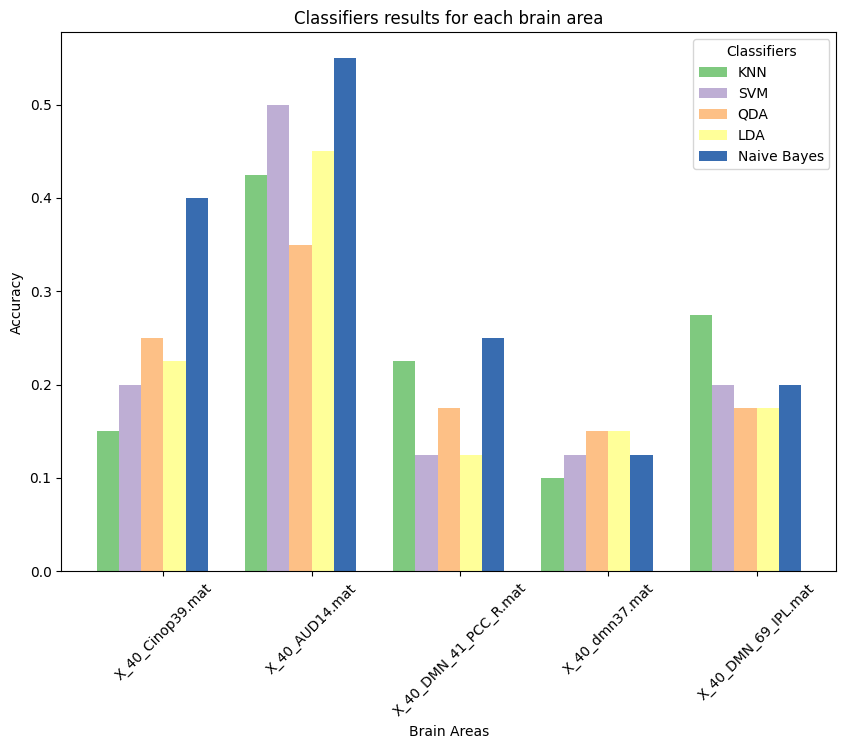

In [ ]:
# Create a list to store the best model's accuracy score and name from each area
best_model_accuracies = []

# Create a list to store the confusion matrices of the best model in each area
confusion_matrices = []

# Create a list to store the accuracy scores for each classifier and area
all_accuracy_scores = []

# List of classifiers
classifiers = ['KNN', 'SVM', 'QDA', 'LDA', 'Naive Bayes']

# Create a list to store the accuracy scores for each classifier in each area
classifier_accuracy_scores = [[] for _ in range(len(classifiers))]

# Iterate over the brain areas
for i in range(len(area_names)):
    # Load data
    df = areas_dataset_bonus_part_one[i][1].copy()

    result_table = pd.DataFrame(columns=['Model Name', 'AUC Score', 'Accuracy CV Score', 'Accuracy Test Score'])

    # Separate features and target
    X = df['Lower_Triangle_FC'].to_list()
    y = df['Output'].astype('int').values

    # Standardize the feature
    scaler = StandardScaler()
    X = scaler.fit_transform(X)

    # Split the data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Define hyperparameters for grid search
    hyperparameters = {
        "KNN": {"n_neighbors": [3, 5, 7, 9, 11]},
        "SVM": {"C": [0.1, 1, 10, 100], "gamma": [1, 0.1, 0.01, 0.001]},
        "QDA": {"reg_param": [0.0, 0.1, 0.2, 0.3, 0.4, 0.5]},
        "LDA": {"solver": ["svd", "lsqr", "eigen"]},
        "Naive Bayes": {}
    }

    # List of models
    models = [
        ("KNN", KNeighborsClassifier()),
        ("SVM", SVC(probability=True)),
        ("QDA", QuadraticDiscriminantAnalysis()),
        ("LDA", LinearDiscriminantAnalysis()),
        ("Naive Bayes",GaussianNB()),
    ]

    # Train and evaluate each model
    model_names = []
    top_models = []

    for name, model in models:
        # Perform grid search to find optimal hyperparameters
        clf = GridSearchCV(model, hyperparameters[name], cv=5)
        clf.fit(X_train, y_train)

        best_model = clf.best_estimator_

        # Apply k-fold Cross Validation
        cv = KFold(n_splits=10, shuffle=False)
        scores = cross_val_score(best_model, X_train, y_train, scoring='accuracy', cv=cv, n_jobs=-1)
        avg_cv_score = np.mean(scores)

        # Predict the labels for the test set
        y_pred = best_model.predict(X_test)

        y_pred_proba = best_model.predict_proba(X_test)
        auc_score = roc_auc_score(y_test, y_pred_proba, multi_class='ovr')

        # Calculate the accuracy on the test set
        test_score = accuracy_score(y_test, y_pred)

        # Store results in the table
        result_table = result_table.append({'Model Name': name,
                                            'AUC Score': auc_score,
                                            'Accuracy CV Score': avg_cv_score,
                                            'Accuracy Test Score': test_score}, ignore_index=True)

        # Store the models and their scores
        top_models.append((name, best_model, avg_cv_score, test_score))
        model_names.append(name)

        # Store the accuracy scores for each classifier in the current area
        classifier_index = classifiers.index(name)
        classifier_accuracy_scores[classifier_index].append(test_score)

    # Sort the result table by AUC score in descending order
    result_table = result_table.sort_values(by='AUC Score', ascending=False)
    # Print the result table
    print(f"\nResults for {area_names[i]}\n")
    print(result_table)


    # Sort models based on their average accuracy score
    top_models.sort(key=lambda x: x[3], reverse=True)

    # Store the best model's accuracy score and name from each area
    best_model_accuracies.append((area_names[i], top_models[0][0], top_models[0][3]))

    # Plot confusion matrix for the best model
    best_model_name, best_model, best_model_cv_score, best_model_test_score = top_models[0]
    y_pred = best_model.predict(X_test)
    cf_matrix = confusion_matrix(y_test, y_pred)

    # Store the confusion matrix of the best model in each area
    confusion_matrices.append((area_names[i], top_models[0][0], cf_matrix))

# Combine the bar plots into one
fig, ax = plt.subplots(figsize=(10, 7))
width = 0.15  # Width of each sub-bar

for i in range(len(classifiers)):
    x = np.arange(len(area_names))
    color = plt.cm.get_cmap('Accent')(i)  # Generate unique color for each classifier

    # Plotting the sub-bars for each brain area
    ax.bar(x + (i * width), classifier_accuracy_scores[i], width=width, color=color, label=classifiers[i])

# Setting up the plot labels and legend
ax.set_xlabel('Brain Areas')
ax.set_ylabel('Accuracy')
ax.set_title('Classifiers results for each brain area')
ax.set_xticks(x + (len(classifiers) / 2 * width))
ax.set_xticklabels(area_names, rotation = 45)
ax.legend(title='Classifiers')

plt.show()


# **Part 2**
**Overview of Part 2: Classification of Five Rest Segments Based on Spatial Pattern**

In this part of the project, we will investigate the classification performance of five distinct rest segments, each lasting 19/20 seconds, extracted from the available data. Given these five rest segments (rest1, rest2, rest3, rest4, rest5), we will be required to classify (with the same classifiers we used in part 1, after new training) which rest segment each subject is in. However, disregard the first rest segment that precedes the initial clip.

**Workflow**:

In the second part of our project, where the objective was to classify each rest segment based on its spatial pattern, our classifiers initially did not yield the desired results. To enhance the performance, we methodically explored and applied a host of techniques:

* Principal Component Analysis (PCA): Our data posed a significant challenge due to its high dimensionality. To tackle this, we implemented PCA to reduce the dimensionality of our data. The new coordinate system of principal components enabled us to focus on the most significant sources of variance in our data, improving the accuracy and efficiency of our classifiers.

* Classifier Tuning: We carefully fine-tuned the parameters of our machine learning models to suit the properties of our standardized, lower-dimension data. This step significantly improved the precision and recall metrics of our models.

* Cross-Validation: We used k-fold cross-validation to obtain a reliable estimate of how our models would perform on unseen data. By splitting the data into 'k' subsets and training and testing the model 'k' times, we managed to provide a more robust measure of accuracy and performance.

By using these techniques, we were able to significantly boost the performance of our classifiers, thereby improving the precision of the predictions concerning the rest segments. This approach laid a solid groundwork for the next stages of our project.

#Functions:

Same as in part 1, only for rest intervals

In [ ]:
def extract_sub_matrices_rest(matrix, start_tr_movie, end_tr_movie, start_tr_rest, end_tr_rest):
    # Initialize an empty dictionary to store the sub-matrices
    sub_matrices = {}

    # Extract the sub-matrices for the rest periods
    for i in range(1, len(start_tr_rest)):
        # Subtract 1 from the start and end time points because Python uses 0-based indexing
        start = start_tr_rest[i] - 1
        end = end_tr_rest[i] - 1
        # Extract the sub-matrix
        sub_matrix = matrix[:, start:end+1]
        # Add the sub-matrix to the dictionary
        sub_matrices[f'Rest {i}'] = sub_matrix

    return sub_matrices


Same as in part 1, only for rest intervals

In [ ]:
def extract_vector_feature_rest(matrix):
    # Extract 5 secs from the 19-20 submatrices
    sub_matrix5 = matrix[:,10:15]
    shape = matrix.shape[0]
    feature = (np.mean(sub_matrix5, axis= 1)).reshape(-1, 1)

    shape_for_pca = feature.shape[1]
    ## Apply PCA
    pca = PCA(n_components=shape_for_pca)  # Adjust n_components as necessary
    feature = pca.fit_transform(feature)
    feature = feature.reshape(shape)

    return sub_matrix5, feature

In [ ]:
# downsample function, not in use - harm results
def running_window_on_vector_feature(vector, n):
  downsample_size = n//128
  if downsample_size:
    offsets = [_ for _ in range(0, vector.shape[0], downsample_size)]
    downsampled_vector = np.array([np.max(vector[offset:offset+n//128]) for offset in offsets])
    return downsampled_vector
  else: return vector

# Bulding the Dataset

In [ ]:
# Initialize an empty list to store the Series
data_list = []

areas_dataset_rest = []

start_tr_movie = [20,284,525,735,818]
end_tr_movie = [264,505,715,798, 901]
start_tr_rest = [1,265,506,716,799,902]
end_tr_rest = [19,283,524,734,819,921]

# Loop over each brain area
for area in range(len(data)):

    df = pd.DataFrame()

    # Loop over each subject
    for subject in range(len(data[area][3,1])):
        # Get the matrix for the current subject in the current brain area
        matrix = data[area][3,1][subject][0]

        # Separate the data into sub-matrices based on different Movies
        sub_matrices = extract_sub_matrices_rest(matrix, start_tr_movie, end_tr_movie, start_tr_rest, end_tr_rest)


        for rest_number, rest in enumerate(list(sub_matrices.values())):
          # Calculate the lower triangle of the FC matrix as a flat array
          five_matrix, feature = extract_vector_feature_rest(rest)


          #downsampled_feature = running_window_on_vector_feature(feature, feature.shape[0])
          new_row = pd.Series({ 'feature_Rest': feature, 'Output': rest_number+1})

          new_row_to_add = new_row.to_frame().T
          df = pd.concat([df, new_row_to_add], ignore_index=True)

    areas_dataset_rest.append((area_names[area], df))


# Models training, prediction and metrices evaluation


Results for X_40_Cinop39.mat

    Model Name  AUC Score  Accuracy CV Score  Accuracy Test Score
1          SVM   0.811947            0.10000                0.125
2          QDA   0.639859            0.29375                0.450
3          LDA   0.497229            0.22500                0.150
0          KNN   0.343533            0.02500                0.050
4  Naive Bayes   0.197432            0.01250                0.025

Results for X_40_AUD14.mat

    Model Name  AUC Score  Accuracy CV Score  Accuracy Test Score
1          SVM   0.803927             0.0875                0.125
2          QDA   0.513271             0.2625                0.325
3          LDA   0.510400             0.2500                0.250
0          KNN   0.249670             0.0750                0.075
4  Naive Bayes   0.207180             0.0250                0.050

Results for X_40_DMN_41_PCC_R.mat

    Model Name  AUC Score  Accuracy CV Score  Accuracy Test Score
1          SVM   0.815225            0.08750  

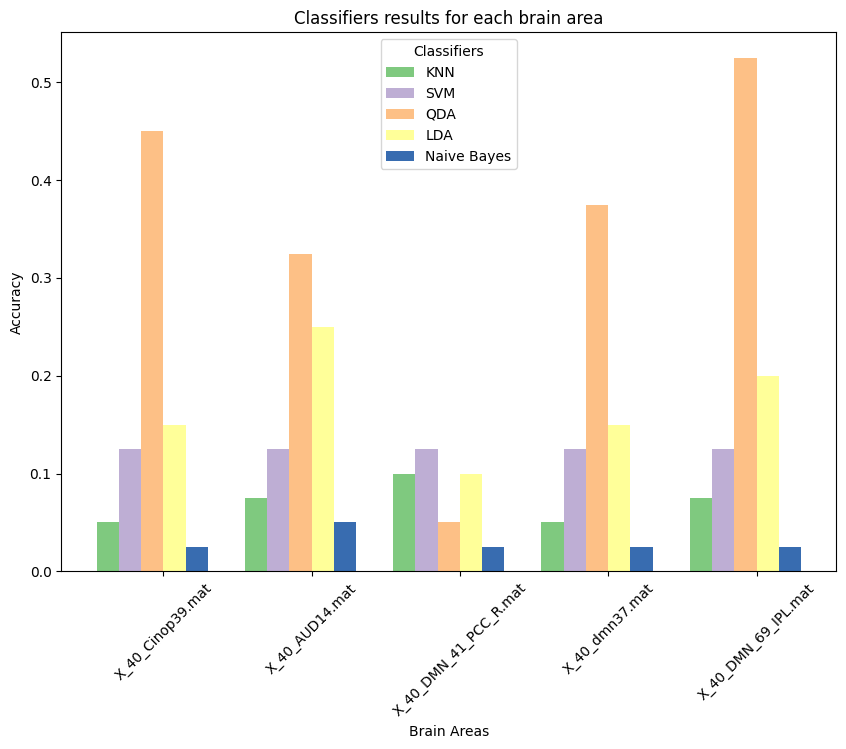

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Create a list to store the best model's accuracy score and name from each area
best_model_accuracies = []

# Create a list to store the confusion matrices of the best model in each area
confusion_matrices = []

# Create a list to store the accuracy scores for each classifier and area
all_accuracy_scores = []

# List of classifiers
classifiers = ['KNN', 'SVM', 'QDA', 'LDA', 'Naive Bayes']

# Create a list to store the accuracy scores for each classifier in each area
classifier_accuracy_scores = [[] for _ in range(len(classifiers))]

# Iterate over the brain areas
for i in range(len(area_names)):
    # Load data
    df = areas_dataset_rest[i][1].copy()

    result_table = pd.DataFrame(columns=['Model Name', 'AUC Score', 'Accuracy CV Score', 'Accuracy Test Score'])

    # Separate features and target
    X = df['feature_Rest'].to_list()
    y = df['Output'].astype('int').values

    # Standardize the features
    scaler = StandardScaler()
    X = scaler.fit_transform(X)

    # Split the data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Define hyperparameters for grid search
    hyperparameters = {
        "KNN": {"n_neighbors": [3, 5, 7, 9, 11]},
        "SVM": {"C": [0.1, 1, 10, 100], "gamma": [1, 0.1, 0.01, 0.001]},
        "QDA": {"reg_param": [0.0, 0.1, 0.2, 0.3, 0.4, 0.5]},
        "LDA": {"solver": ["svd", "lsqr", "eigen"]},
        "Naive Bayes": {}
    }

    # List of models
    models = [
        ("KNN", KNeighborsClassifier()),
        ("SVM", SVC(probability=True)),
        ("QDA", QuadraticDiscriminantAnalysis()),
        ("LDA", LinearDiscriminantAnalysis()),
        ("Naive Bayes",GaussianNB()),
    ]

    # Train and evaluate each model
    model_names = []
    top_models = []

    for name, model in models:
        # Perform grid search to find optimal hyperparameters
        clf = GridSearchCV(model, hyperparameters[name], cv=5)
        clf.fit(X_train, y_train)

        best_model = clf.best_estimator_

        # Apply k-fold Cross Validation
        cv = KFold(n_splits=10, random_state=42, shuffle=True)
        scores = cross_val_score(best_model, X_train, y_train, scoring='accuracy', cv=cv, n_jobs=-1)
        avg_cv_score = np.mean(scores)

        # Predict the labels for the test set
        y_pred = best_model.predict(X_test)

        y_pred_proba = best_model.predict_proba(X_test)
        auc_score = roc_auc_score(y_test, y_pred_proba, multi_class='ovr')

        # Calculate the accuracy on the test set
        test_score = accuracy_score(y_test, y_pred)

        # Store results in the table
        result_table = result_table.append({'Model Name': name,
                                            'AUC Score': auc_score,
                                            'Accuracy CV Score': avg_cv_score,
                                            'Accuracy Test Score': test_score}, ignore_index=True)

        # Store the models and their scores
        top_models.append((name, best_model, avg_cv_score, test_score))
        model_names.append(name)

        # Store the accuracy scores for each classifier in the current area
        classifier_index = classifiers.index(name)
        classifier_accuracy_scores[classifier_index].append(test_score)

    # Sort the result table by AUC score in descending order
    result_table = result_table.sort_values(by='AUC Score', ascending=False)
    # Print the result table
    print(f"\nResults for {area_names[i]}\n")
    print(result_table)


    # Sort models based on their average accuracy score
    top_models.sort(key=lambda x: x[3], reverse=True)

    # Store the best model's accuracy score and name from each area
    best_model_accuracies.append((area_names[i], top_models[0][0], top_models[0][3]))

    # Plot confusion matrix for the best model
    best_model_name, best_model, best_model_cv_score, best_model_test_score = top_models[0]
    y_pred = best_model.predict(X_test)
    cf_matrix = confusion_matrix(y_test, y_pred)

    # Store the confusion matrix of the best model in each area
    confusion_matrices.append((area_names[i], top_models[0][0], cf_matrix))

# Combine the bar plots into one
fig, ax = plt.subplots(figsize=(10, 7))
width = 0.15  # Width of each sub-bar

for i in range(len(classifiers)):
    x = np.arange(len(area_names))
    color = plt.cm.get_cmap('Accent')(i)  # Generate unique color for each classifier

    # Plotting the sub-bars for each brain area
    ax.bar(x + (i * width), classifier_accuracy_scores[i], width=width, color=color, label=classifiers[i])

# Setting up the plot labels and legend
ax.set_xlabel('Brain Areas')
ax.set_ylabel('Accuracy')
ax.set_title('Classifiers results for each brain area')
ax.set_xticks(x + (len(classifiers) / 2 * width))
ax.set_xticklabels(area_names, rotation = 45)
ax.legend(title='Classifiers')

plt.show()


In [ ]:
combined_list = [(a[0], a[1], a[2], c[2]) for a, c in zip(best_model_accuracies, confusion_matrices)]

combined_list_sorted = sorted(combined_list, key=lambda x: x[2], reverse=True)

Confusion matrices based on the best model accuracy in the top 3 areas with best accuracy score:





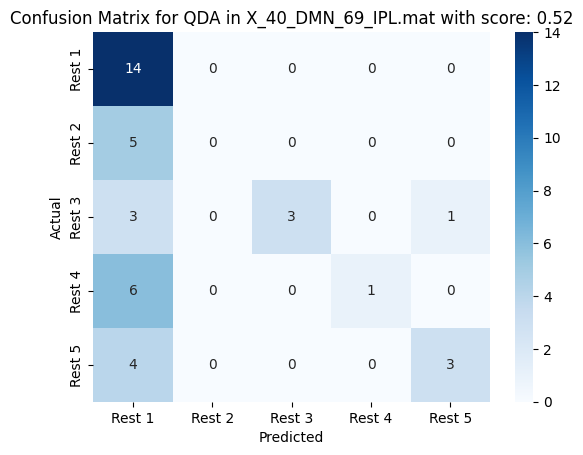

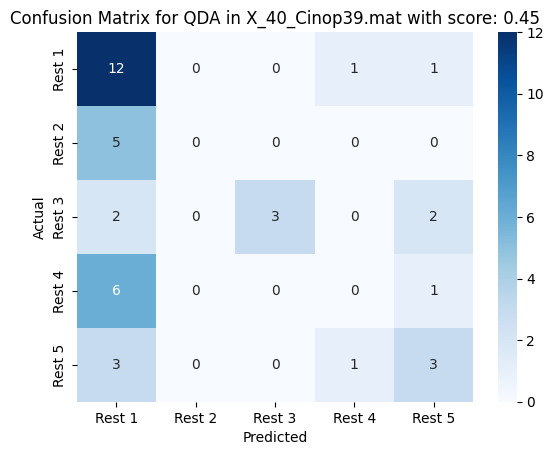

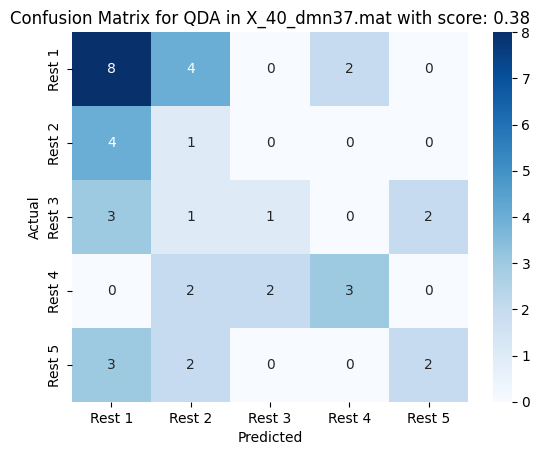

In [ ]:
print("Confusion matrices based on the best model accuracy in the top 3 areas with best accuracy score:")
labels = ['Rest 1', 'Rest 2', 'Rest 3', 'Rest 4', 'Rest 5']
for i in range(0,3):
  confusion_matrix_plot(combined_list_sorted[i][3], area_name=combined_list_sorted[i][0], best_model_name=combined_list_sorted[i][1], best_model_score=combined_list_sorted[i][2], labels=labels)

# Bonus - Part 2

In [ ]:
def extract_vector_feature_rest_bonus_2(matrix, time_interval):
    # Extract 5 secs
    sub_matrix5 = matrix[:,time_interval[0]-1:time_interval[-1]]
    shape = matrix.shape[0]
    feature = (np.mean(sub_matrix5, axis= 1)).reshape(-1, 1)

    shape_for_pca = feature.shape[1]
    ## Apply PCA
    pca = PCA(n_components=shape_for_pca)  # Adjust n_components as necessary
    feature = pca.fit_transform(feature)
    feature = feature.reshape(shape)

    return sub_matrix5, feature

In [ ]:
# Initialize an empty list to store the Series
data_list = []

# Initialize a list to store datasets for each sub-phase
datasets_subphase_bonus_part_2 = []

areas_dataset_rest = []

# Define time intervals
time_intervals = [(1,5), (6,10), (11,15), (16,19)]

start_tr_movie = [20,284,525,735,818]
end_tr_movie = [264,505,715,798, 901]
start_tr_rest = [1,265,506,716,799,902]
end_tr_rest = [19,283,524,734,819,921]

for time_interval in time_intervals:

  areas_dataset_rest = []
  # Loop over each brain area
  for area in range(len(data)):

      df = pd.DataFrame()

      # Loop over each subject
      for subject in range(len(data[area][3,1])):
          # Get the matrix for the current subject in the current brain area
          matrix = data[area][3,1][subject][0]

          # Separate the data into sub-matrices based on different Movies
          sub_matrices = extract_sub_matrices_rest(matrix, start_tr_movie, end_tr_movie, start_tr_rest, end_tr_rest)

          for rest_number, rest in enumerate(list(sub_matrices.values())):
            # Calculate the lower triangle of the FC matrix as a flat array
            #print(movie_number)
            five_matrix, feature = extract_vector_feature_rest_bonus_2(rest, time_interval)


            #downsampled_feature = running_window_on_vector_feature(feature, feature.shape[0])
            new_row = pd.Series({ 'feature_Rest': feature, 'Output': rest_number+1})

            new_row_to_add = new_row.to_frame().T
            df = pd.concat([df, new_row_to_add], ignore_index=True)

      areas_dataset_rest.append((area_names[area], df))
  datasets_subphase_bonus_part_2.append((time_interval, areas_dataset_rest))
  # Now 'df' is a MultiIndex DataFrame with the matrix shapes for each subject in each brain area
  #areas_dataset

In [ ]:
datasets_subphase_bonus_part_2[3][0]

(16, 19)

Results in Average Spatial Pattern:

Results for rest time interval: (1, 5)

Results for X_40_Cinop39.mat

    Model Name  AUC Score  Accuracy CV Score  Accuracy Test Score
1          SVM   0.821800            0.08750                0.125
2          QDA   0.586149            0.34375                0.400
3          LDA   0.525974            0.18750                0.300
0          KNN   0.321210            0.03750                0.050
4  Naive Bayes   0.229643            0.00000                0.050

Results for X_40_AUD14.mat

    Model Name  AUC Score  Accuracy CV Score  Accuracy Test Score
1          SVM   0.745923            0.08750                0.125
3          LDA   0.496364            0.18125                0.150
2          QDA   0.477508            0.26875                0.350
0          KNN   0.254679            0.06250                0.025
4  Naive Bayes   0.204460            0.02500                0.025

Results for X_40_DMN_41_PCC_R.mat

    Model Name  AUC Score  Accuracy 

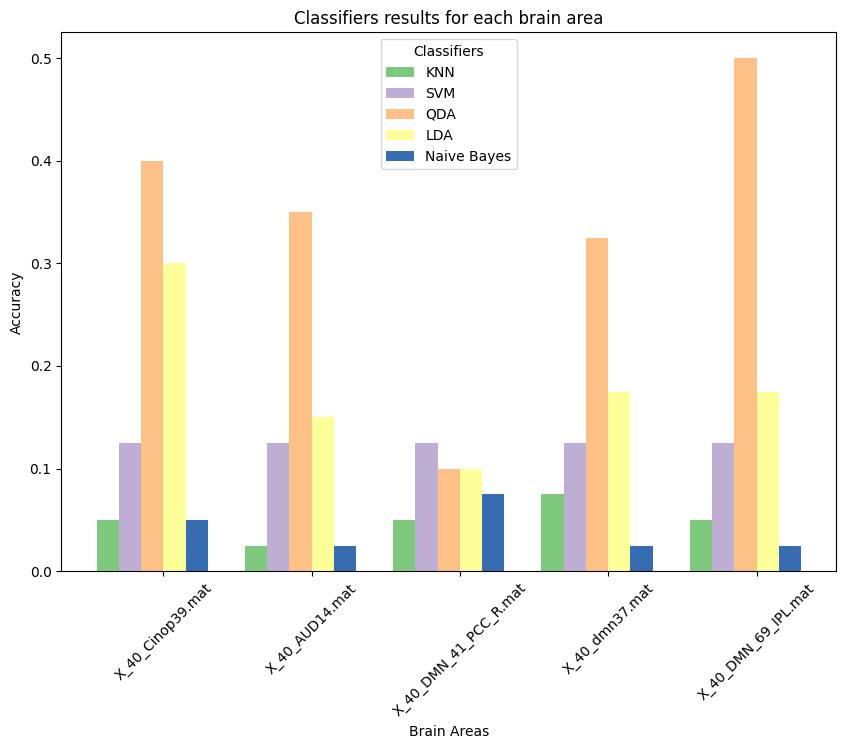

Results for rest time interval: (6, 10)

Results for X_40_Cinop39.mat

    Model Name  AUC Score  Accuracy CV Score  Accuracy Test Score
1          SVM   0.730322            0.08750                0.125
2          QDA   0.583112            0.35000                0.450
3          LDA   0.551948            0.25000                0.250
0          KNN   0.289736            0.04375                0.050
4  Naive Bayes   0.240617            0.00625                0.050

Results for X_40_AUD14.mat

    Model Name  AUC Score  Accuracy CV Score  Accuracy Test Score
1          SVM   0.762980            0.08750                0.125
2          QDA   0.510926            0.28125                0.300
3          LDA   0.454962            0.19375                0.125
0          KNN   0.249887            0.06250                0.050
4  Naive Bayes   0.208002            0.01875                0.050

Results for X_40_DMN_41_PCC_R.mat

    Model Name  AUC Score  Accuracy CV Score  Accuracy Test Score
1     

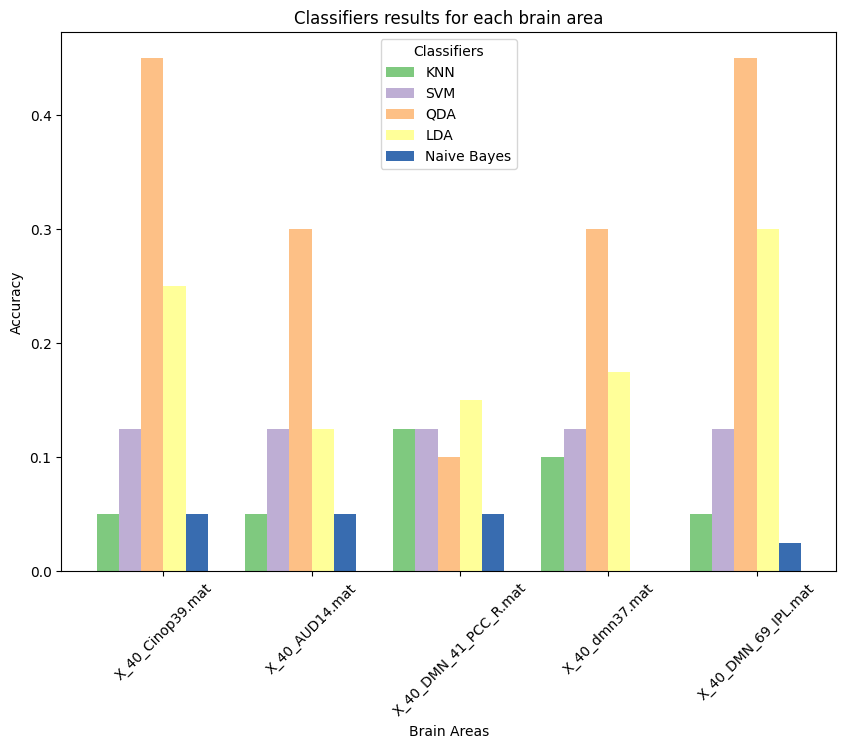

Results for rest time interval: (11, 15)

Results for X_40_Cinop39.mat

    Model Name  AUC Score  Accuracy CV Score  Accuracy Test Score
1          SVM   0.736547            0.10000                0.125
2          QDA   0.639859            0.29375                0.450
3          LDA   0.497229            0.22500                0.150
0          KNN   0.343533            0.02500                0.050
4  Naive Bayes   0.197432            0.01250                0.025

Results for X_40_AUD14.mat

    Model Name  AUC Score  Accuracy CV Score  Accuracy Test Score
1          SVM   0.834513             0.0875                0.125
2          QDA   0.513271             0.2625                0.325
3          LDA   0.510400             0.2500                0.250
0          KNN   0.249670             0.0750                0.075
4  Naive Bayes   0.207180             0.0250                0.050

Results for X_40_DMN_41_PCC_R.mat

    Model Name  AUC Score  Accuracy CV Score  Accuracy Test Score
1    

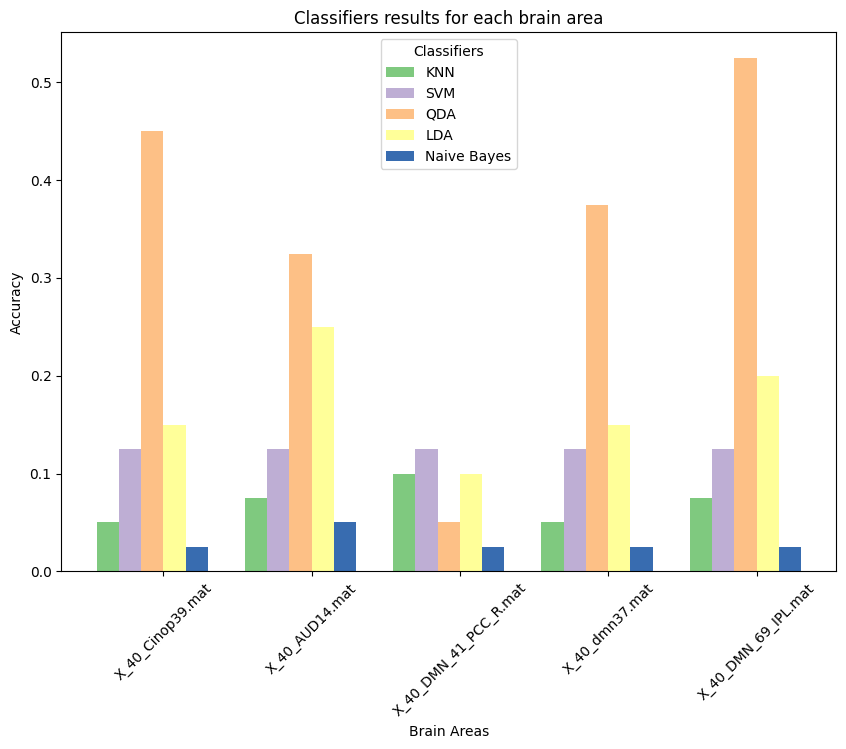

Results for rest time interval: (16, 19)

Results for X_40_Cinop39.mat

    Model Name  AUC Score  Accuracy CV Score  Accuracy Test Score
1          SVM   0.803231            0.09375                0.125
2          QDA   0.576754            0.27500                0.425
3          LDA   0.508312            0.20625                0.175
0          KNN   0.266558            0.01250                0.075
4  Naive Bayes   0.216412            0.00625                0.050

Results for X_40_AUD14.mat

    Model Name  AUC Score  Accuracy CV Score  Accuracy Test Score
1          SVM   0.763007            0.08750                0.125
3          LDA   0.480819            0.17500                0.175
2          QDA   0.475299            0.27500                0.275
0          KNN   0.235181            0.06250                0.100
4  Naive Bayes   0.205647            0.03125                0.025

Results for X_40_DMN_41_PCC_R.mat

    Model Name  AUC Score  Accuracy CV Score  Accuracy Test Score
1    

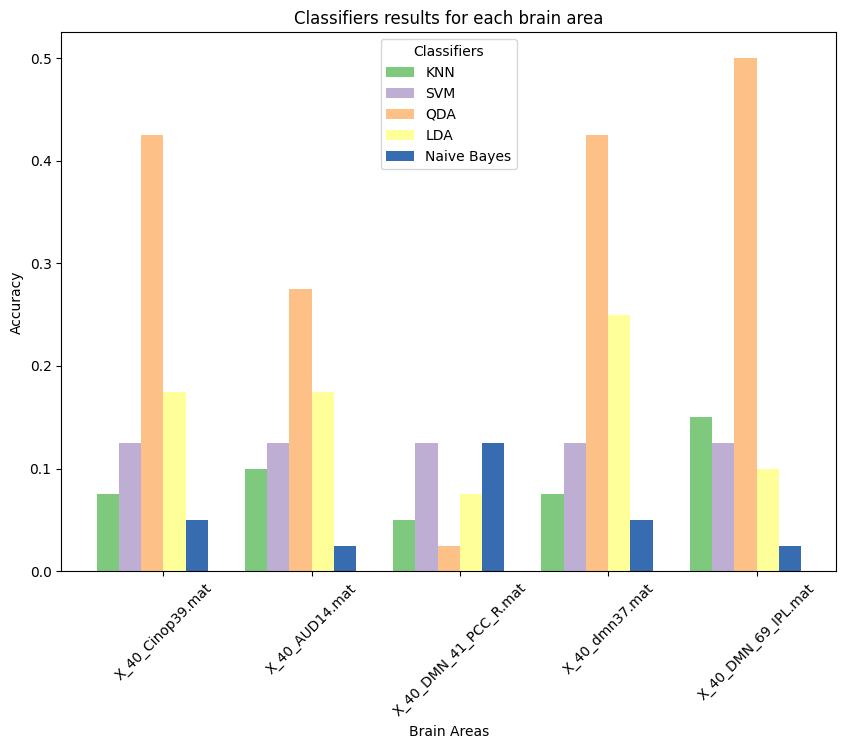

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

print(f"Results in Average Spatial Pattern:\n")

for areas_dataset_rest in datasets_subphase_bonus_part_2:

  print(f"Results for rest time interval: {areas_dataset_rest[0]}")

  # Create a list to store the best model's accuracy score and name from each area
  best_model_accuracies = []

  # Create a list to store the confusion matrices of the best model in each area
  confusion_matrices = []

  # Create a list to store the accuracy scores for each classifier and area
  all_accuracy_scores = []

  # List of classifiers
  classifiers = ['KNN', 'SVM', 'QDA', 'LDA', 'Naive Bayes']

  # Create a list to store the accuracy scores for each classifier in each area
  classifier_accuracy_scores = [[] for _ in range(len(classifiers))]

  # Iterate over the brain areas
  for i in range(len(area_names)):
      # Load data
      df = areas_dataset_rest[1][i][1].copy()

      result_table = pd.DataFrame(columns=['Model Name', 'AUC Score', 'Accuracy CV Score', 'Accuracy Test Score'])

      # Separate features and target
      X = df['feature_Rest'].to_list()
      y = df['Output'].astype('int').values

      # Standardize the features
      scaler = StandardScaler()
      X = scaler.fit_transform(X)

      # Split the data into training and testing sets
      X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

      # Define hyperparameters for grid search
      hyperparameters = {
          "KNN": {"n_neighbors": [3, 5, 7, 9, 11]},
          "SVM": {"C": [0.1, 1, 10, 100], "gamma": [1, 0.1, 0.01, 0.001]},
          "QDA": {"reg_param": [0.0, 0.1, 0.2, 0.3, 0.4, 0.5]},
          "LDA": {"solver": ["svd", "lsqr", "eigen"]},
          "Naive Bayes": {}
      }

      # List of models
      models = [
          ("KNN", KNeighborsClassifier()),
          ("SVM", SVC(probability=True)),
          ("QDA", QuadraticDiscriminantAnalysis()),
          ("LDA", LinearDiscriminantAnalysis()),
          ("Naive Bayes",GaussianNB()),
      ]

      # Train and evaluate each model
      model_names = []
      top_models = []

      for name, model in models:
          # Perform grid search to find optimal hyperparameters
          clf = GridSearchCV(model, hyperparameters[name], cv=5)
          clf.fit(X_train, y_train)

          best_model = clf.best_estimator_

          # Apply k-fold Cross Validation
          cv = KFold(n_splits=10, random_state=42, shuffle=True)
          scores = cross_val_score(best_model, X_train, y_train, scoring='accuracy', cv=cv, n_jobs=-1)
          avg_cv_score = np.mean(scores)

          # Predict the labels for the test set
          y_pred = best_model.predict(X_test)

          y_pred_proba = best_model.predict_proba(X_test)
          auc_score = roc_auc_score(y_test, y_pred_proba, multi_class='ovr')

          # Calculate the accuracy on the test set
          test_score = accuracy_score(y_test, y_pred)

          # Store results in the table
          result_table = result_table.append({'Model Name': name,
                                              'AUC Score': auc_score,
                                              'Accuracy CV Score': avg_cv_score,
                                              'Accuracy Test Score': test_score}, ignore_index=True)

          # Store the models and their scores
          top_models.append((name, best_model, avg_cv_score, test_score))
          model_names.append(name)

          # Store the accuracy scores for each classifier in the current area
          classifier_index = classifiers.index(name)
          classifier_accuracy_scores[classifier_index].append(test_score)

      # Sort the result table by AUC score in descending order
      result_table = result_table.sort_values(by='AUC Score', ascending=False)
      # Print the result table
      print(f"\nResults for {area_names[i]}\n")
      print(result_table)


      # Sort models based on their average accuracy score
      top_models.sort(key=lambda x: x[3], reverse=True)

      # Store the best model's accuracy score and name from each area
      best_model_accuracies.append((area_names[i], top_models[0][0], top_models[0][3]))

      # Plot confusion matrix for the best model
      best_model_name, best_model, best_model_cv_score, best_model_test_score = top_models[0]
      y_pred = best_model.predict(X_test)
      cf_matrix = confusion_matrix(y_test, y_pred)

      # Store the confusion matrix of the best model in each area
      confusion_matrices.append((area_names[i], top_models[0][0], cf_matrix))

  # Combine the bar plots into one
  fig, ax = plt.subplots(figsize=(10, 7))
  width = 0.15  # Width of each sub-bar

  for i in range(len(classifiers)):
      x = np.arange(len(area_names))
      color = plt.cm.get_cmap('Accent')(i)  # Generate unique color for each classifier

      # Plotting the sub-bars for each brain area
      ax.bar(x + (i * width), classifier_accuracy_scores[i], width=width, color=color, label=classifiers[i])

  # Setting up the plot labels and legend
  ax.set_xlabel('Brain Areas')
  ax.set_ylabel('Accuracy')
  ax.set_title('Classifiers results for each brain area')
  ax.set_xticks(x + (len(classifiers) / 2 * width))
  ax.set_xticklabels(area_names, rotation = 45)
  ax.legend(title='Classifiers')

  plt.show()

# **Part 3**
**Overview of Part 3: Classification of Rest Segments Based on Inter-segment Similarity**

In the third part of our project, we focus on classifying each rest segment according to its similarity to other rest segments. This is achieved by extracting spatial patterns (voxel vectors) from the middle of each rest segment, which are then used to generate a correlation matrix forming the basis of our classification. We evaluate the accuracy of our classifiers (the same (classifiers we used before) using k-fold cross-validation, with the results showcased in detailed bar plots. In addition, we conduct a confusion matrix analysis for the best-performing classifiers within the top three highest-classified networks.

**Workflow:**
To optimize these results and increase our model's performance, we systematically incorporated and applied several methods:

* Classifier Optimization: We performed comprehensive tuning of our classifier's hyperparameters to suit the properties of our standardized data. This tuning process significantly improved the precision and recall metrics of our models, thereby leading to a more accurate and robust classification.

* Cross-Validation: To ensure a reliable and unbiased evaluation of our model's performance, we used k-fold cross-validation. This process, which involves training and testing the model on different subsets of data, provided a more robust measure of model accuracy.

By adopting these techniques, we significantly boosted the performance of our classification models. The optimized models could classify the rest segments more accurately, providing a substantial foundation for the subsequent stages of our project.


# Functions

In [ ]:
def extract_sub_matrices_rest(matrix, start_tr_movie, end_tr_movie, start_tr_rest, end_tr_rest):
    # Initialize an empty dictionary to store the sub-matrices
    sub_matrices = {}

    # Extract the sub-matrices for the rest periods
    for i in range(1, len(start_tr_rest)):
        # Subtract 1 from the start and end time points because Python uses 0-based indexing
        start = start_tr_rest[i] - 1
        end = end_tr_rest[i] - 1
        # Extract the sub-matrix
        sub_matrix = matrix[:, start:end+1]
        # Add the sub-matrix to the dictionary
        sub_matrices[f'Rest {i}'] = sub_matrix

    return sub_matrices


In [ ]:
def extract_vector_feature_rest_distance(matrix):
    # Extract 5 secs from the 19-20 submatrices
    sub_matrix5 = matrix[:,10:15]
    shape = matrix.shape[0]
    feature = (np.mean(sub_matrix5, axis= 1)).reshape(-1, 1)

    return sub_matrix5, feature

# Building the data set:

In [ ]:
# Initialize an empty list to store the Series
data_list = []

areas_dataset_rest = []

start_tr_movie = [20,284,525,735,818]
end_tr_movie = [264,505,715,798, 901]
start_tr_rest = [1,265,506,716,799,902]
end_tr_rest = [19,283,524,734,819,921]

# Loop over each brain area
for area in range(len(data)):

    df = pd.DataFrame()

    # Loop over each subject
    for subject in range(len(data[area][3,1])):
        # Get the matrix for the current subject in the current brain area
        matrix = data[area][3,1][subject][0]

        # Separate the data into sub-matrices based on different Movies
        sub_matrices = extract_sub_matrices_rest(matrix, start_tr_movie, end_tr_movie, start_tr_rest, end_tr_rest)

        columns_array = []

        for rest_number, rest in enumerate(list(sub_matrices.values())):
          # Calculate the lower triangle of the FC matrix as a flat array
          #print(movie_number)
          five_matrix, column = extract_vector_feature_rest_distance(rest)

          columns_array.append(column)


        columns_matrix = np.column_stack(columns_array)
        correlation_matrix = np.corrcoef(columns_matrix.T)

        ## Apply PCA
        pca = PCA(n_components=5)  # Adjust n_components as necessary
        correlation_matrix = pca.fit_transform(correlation_matrix)


        for i in range(correlation_matrix.shape[0]):
          row_to_insert = correlation_matrix[i]
          row_to_insert = np.delete(row_to_insert, i)
          new_row = pd.Series({'feature': row_to_insert, 'Output': i+1})


          new_row_to_add = new_row.to_frame().T
          df = pd.concat([df, new_row_to_add], ignore_index=True)

    areas_dataset_rest.append((area_names[area], df))




# Models training, prediction and metrics evaluation


Results for X_40_Cinop39.mat

    Model Name  AUC Score  Accuracy CV Score  Accuracy Test Score
1          SVM   0.799449            0.37500                0.500
4  Naive Bayes   0.788443            0.48125                0.500
2          QDA   0.732933            0.43750                0.450
0          KNN   0.704318            0.33125                0.525
3          LDA   0.449479            0.20000                0.175

Results for X_40_AUD14.mat

    Model Name  AUC Score  Accuracy CV Score  Accuracy Test Score
2          QDA   0.767985            0.42500                0.550
4  Naive Bayes   0.752095            0.40000                0.375
0          KNN   0.697690            0.31250                0.375
1          SVM   0.686813            0.35625                0.325
3          LDA   0.492659            0.21250                0.125

Results for X_40_DMN_41_PCC_R.mat

    Model Name  AUC Score  Accuracy CV Score  Accuracy Test Score
1          SVM   0.794754            0.48750  

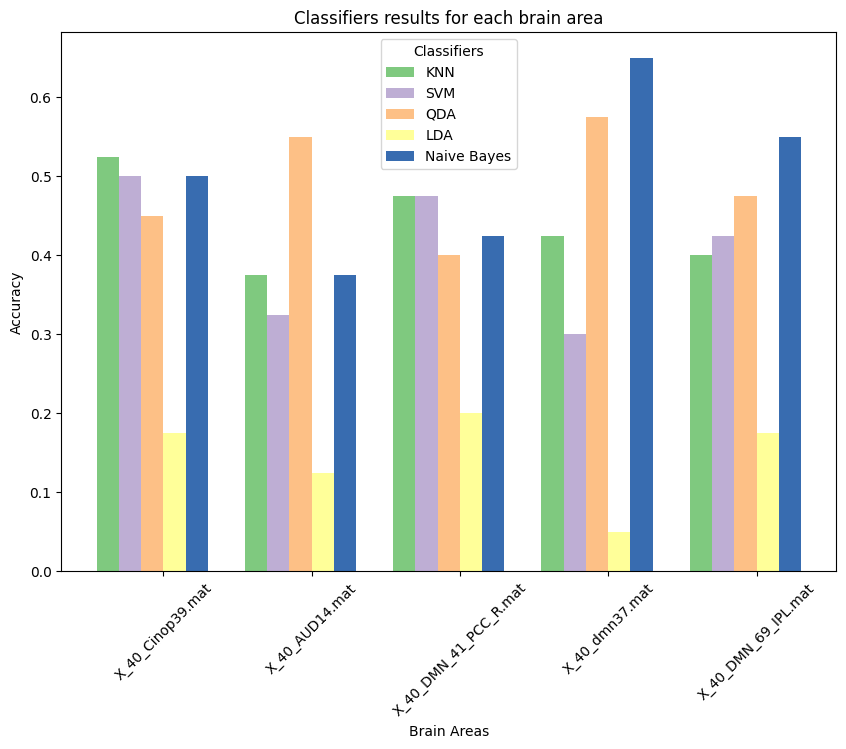

In [ ]:

# Create a list to store the best model's accuracy score and name from each area
best_model_accuracies = []

# Create a list to store the confusion matrices of the best model in each area
confusion_matrices = []

# Create a list to store the accuracy scores for each classifier and area
all_accuracy_scores = []

# List of classifiers
classifiers = ['KNN', 'SVM', 'QDA', 'LDA', 'Naive Bayes']

# Create a list to store the accuracy scores for each classifier in each area
classifier_accuracy_scores = [[] for _ in range(len(classifiers))]

# Iterate over the brain areas
for i in range(len(area_names)):
    # Load data
    df = areas_dataset_rest[i][1].copy()

    result_table = pd.DataFrame(columns=['Model Name', 'AUC Score', 'Accuracy CV Score', 'Accuracy Test Score'])

    # Separate features and target
    X = df['feature'].to_list()
    y = df['Output'].astype('int').values

    # Standardize the features
    scaler = StandardScaler()
    X = scaler.fit_transform(X)

    # Split the data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Define hyperparameters for grid search
    hyperparameters = {
        "KNN": {"n_neighbors": [3, 5, 7, 9, 11]},
        "SVM": {"C": [0.1, 1, 10, 100], "gamma": [1, 0.1, 0.01, 0.001]},
        "QDA": {"reg_param": [0.0, 0.1, 0.2, 0.3, 0.4, 0.5]},
        "LDA": {"solver": ["svd", "lsqr", "eigen"]},
        "Naive Bayes": {}
    }

    # List of models
    models = [
        ("KNN", KNeighborsClassifier()),
        ("SVM", SVC(probability=True)),
        ("QDA", QuadraticDiscriminantAnalysis()),
        ("LDA", LinearDiscriminantAnalysis()),
        ("Naive Bayes",GaussianNB()),
    ]

    # Train and evaluate each model
    model_names = []
    top_models = []

    for name, model in models:
        # Perform grid search to find optimal hyperparameters
        clf = GridSearchCV(model, hyperparameters[name], cv=5)
        clf.fit(X_train, y_train)

        best_model = clf.best_estimator_

        # Apply k-fold Cross Validation
        cv = KFold(n_splits=10, random_state=42, shuffle=True)
        scores = cross_val_score(best_model, X_train, y_train, scoring='accuracy', cv=cv, n_jobs=-1)
        avg_cv_score = np.mean(scores)

        # Predict the labels for the test set
        y_pred = best_model.predict(X_test)

        y_pred_proba = best_model.predict_proba(X_test)
        auc_score = roc_auc_score(y_test, y_pred_proba, multi_class='ovr')

        # Calculate the accuracy on the test set
        test_score = accuracy_score(y_test, y_pred)

        # Store results in the table
        result_table = result_table.append({'Model Name': name,
                                            'AUC Score': auc_score,
                                            'Accuracy CV Score': avg_cv_score,
                                            'Accuracy Test Score': test_score}, ignore_index=True)

        # Store the models and their scores
        top_models.append((name, best_model, avg_cv_score, test_score))
        model_names.append(name)

        # Store the accuracy scores for each classifier in the current area
        classifier_index = classifiers.index(name)
        classifier_accuracy_scores[classifier_index].append(test_score)

    # Sort the result table by AUC score in descending order
    result_table = result_table.sort_values(by='AUC Score', ascending=False)
    # Print the result table
    print(f"\nResults for {area_names[i]}\n")
    print(result_table)


    # Sort models based on their average accuracy score
    top_models.sort(key=lambda x: x[3], reverse=True)

    # Store the best model's accuracy score and name from each area
    best_model_accuracies.append((area_names[i], top_models[0][0], top_models[0][3]))

    # Plot confusion matrix for the best model
    best_model_name, best_model, best_model_cv_score, best_model_test_score = top_models[0]
    y_pred = best_model.predict(X_test)
    cf_matrix = confusion_matrix(y_test, y_pred)

    # Store the confusion matrix of the best model in each area
    confusion_matrices.append((area_names[i], top_models[0][0], cf_matrix))

# Combine the bar plots into one
fig, ax = plt.subplots(figsize=(10, 7))
width = 0.15  # Width of each sub-bar

for i in range(len(classifiers)):
    x = np.arange(len(area_names))
    color = plt.cm.get_cmap('Accent')(i)  # Generate unique color for each classifier

    # Plotting the sub-bars for each brain area
    ax.bar(x + (i * width), classifier_accuracy_scores[i], width=width, color=color, label=classifiers[i])

# Setting up the plot labels and legend
ax.set_xlabel('Brain Areas')
ax.set_ylabel('Accuracy')
ax.set_title('Classifiers results for each brain area')
ax.set_xticks(x + (len(classifiers) / 2 * width))
ax.set_xticklabels(area_names, rotation = 45)
ax.legend(title='Classifiers')

plt.show()


In [ ]:
combined_list = [(a[0], a[1], a[2], c[2]) for a, c in zip(best_model_accuracies, confusion_matrices)]

combined_list_sorted = sorted(combined_list, key=lambda x: x[2], reverse=True)

Confusion matrices based on the best model accuracy in the top 3 areas with best accuracy score:





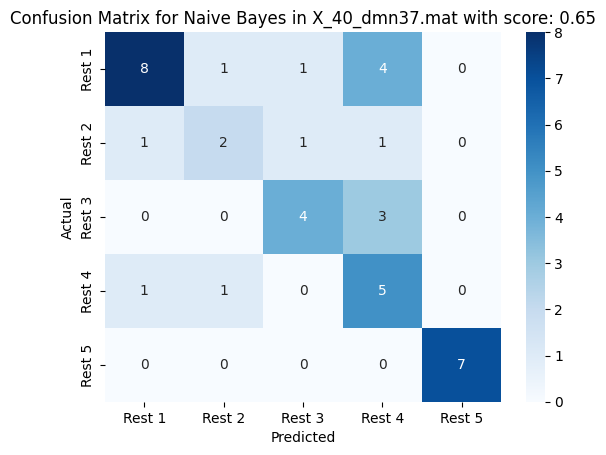

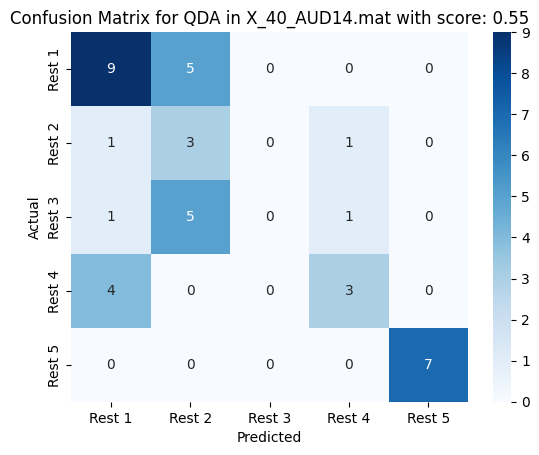

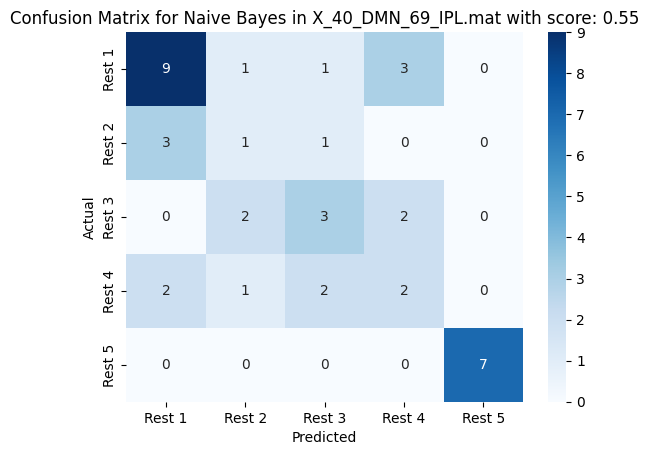

In [ ]:
print("Confusion matrices based on the best model accuracy in the top 3 areas with best accuracy score:")
labels=["Rest 1", "Rest 2", "Rest 3", "Rest 4", "Rest 5"]
for i in range(0,3):
  confusion_matrix_plot(combined_list_sorted[i][3], area_name=combined_list_sorted[i][0], best_model_name=combined_list_sorted[i][1], best_model_score=combined_list_sorted[i][2], labels=labels)

**Questions**:

1. Should we perform transpose on the matrix to get 5x5 matrix after the corrcoef opertaion

2. How come the 'part 3' correlation matrix have so high correlation

3. Is that okay to insert PCA and other data-preperation methods in the process of extracting the data?



# Bonus - Part 3

In [ ]:
def extract_vector_feature_rest_distance_bonus(matrix, time_interval):
    # Extract 5 secs from the 19-20 submatrices
    sub_matrix5 = matrix[:,time_interval[0]-1:time_interval[-1]]
    shape = matrix.shape[0]
    feature = (np.mean(sub_matrix5, axis= 1)).reshape(-1, 1)

    return sub_matrix5, feature

In [ ]:
# Define time intervals
time_intervals = [(1,5), (6,10), (11,15), (16,19)]

# Initialize a list to store datasets for each sub-phase
datasets_subphase = []

start_tr_movie = [20,284,525,735,818]
end_tr_movie = [264,505,715,798, 901]
start_tr_rest = [1,265,506,716,799,902]
end_tr_rest = [19,283,524,734,819,921]

# Initialize an empty list to store the Series
data_list = []

for time_interval in time_intervals:
  areas_dataset_rest = []
  # Loop over each brain area
  for area in range(len(data)):

      df = pd.DataFrame()

      # Loop over each subject
      for subject in range(len(data[area][3,1])):
          # Get the matrix for the current subject in the current brain area
          matrix = data[area][3,1][subject][0]

          # Separate the data into sub-matrices based on different Movies
          sub_matrices = extract_sub_matrices_rest(matrix, start_tr_movie, end_tr_movie, start_tr_rest, end_tr_rest)

          columns_array = []

          for rest_number, rest in enumerate(list(sub_matrices.values())):
            # Calculate the lower triangle of the FC matrix as a flat array
            #print(movie_number)
            five_matrix, column = extract_vector_feature_rest_distance_bonus(rest, time_interval)

            columns_array.append(column)


          columns_matrix = np.column_stack(columns_array)
          correlation_matrix = np.corrcoef(columns_matrix.T)

          ## Apply PCA
          pca = PCA(n_components=5)  # Adjust n_components as necessary
          correlation_matrix = pca.fit_transform(correlation_matrix)



          for i in range(correlation_matrix.shape[0]):
            row_to_insert = correlation_matrix[i]
            row_to_insert = np.delete(row_to_insert, i)

            new_row = pd.Series({'feature': row_to_insert, 'Output': i+1})


            new_row_to_add = new_row.to_frame().T
            df = pd.concat([df, new_row_to_add], ignore_index=True)

      areas_dataset_rest.append((area_names[area], df))
  datasets_subphase.append((time_interval, areas_dataset_rest))



Results in Distance vector method:

Results for rest time interval: (1, 5)

Results for X_40_Cinop39.mat

    Model Name  AUC Score  Accuracy CV Score  Accuracy Test Score
1          SVM   0.796545            0.40625                0.400
2          QDA   0.753197            0.46875                0.375
4  Naive Bayes   0.736724            0.48125                0.325
0          KNN   0.624457            0.37500                0.325
3          LDA   0.556230            0.22500                0.200

Results for X_40_AUD14.mat

    Model Name  AUC Score  Accuracy CV Score  Accuracy Test Score
4  Naive Bayes   0.783191            0.48125                0.475
2          QDA   0.780942            0.49375                0.475
1          SVM   0.709957            0.43125                0.325
0          KNN   0.699189            0.41875                0.425
3          LDA   0.661893            0.24375                0.200

Results for X_40_DMN_41_PCC_R.mat

    Model Name  AUC Score  Accuracy C

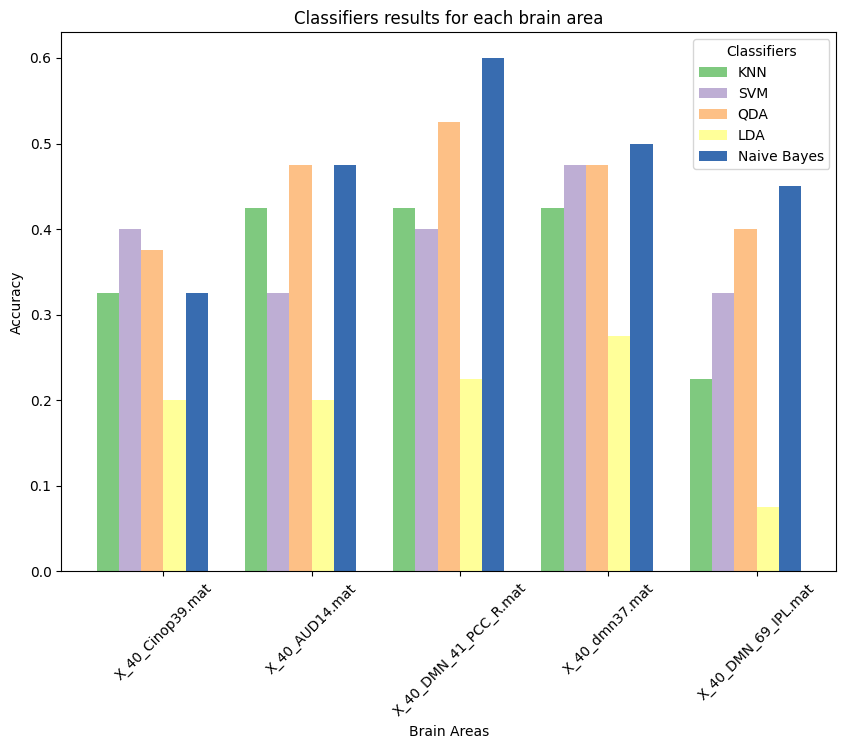

Results for rest time interval: (6, 10)

Results for X_40_Cinop39.mat

    Model Name  AUC Score  Accuracy CV Score  Accuracy Test Score
2          QDA   0.763074            0.45625                0.525
4  Naive Bayes   0.757908            0.43750                0.525
1          SVM   0.685923            0.36250                0.400
0          KNN   0.668676            0.37500                0.475
3          LDA   0.538723            0.26875                0.225

Results for X_40_AUD14.mat

    Model Name  AUC Score  Accuracy CV Score  Accuracy Test Score
4  Naive Bayes   0.735182            0.46875                0.525
1          SVM   0.695218            0.45000                0.475
2          QDA   0.669076            0.43125                0.475
0          KNN   0.614346            0.45625                0.425
3          LDA   0.583235            0.19375                0.200

Results for X_40_DMN_41_PCC_R.mat

    Model Name  AUC Score  Accuracy CV Score  Accuracy Test Score
2     

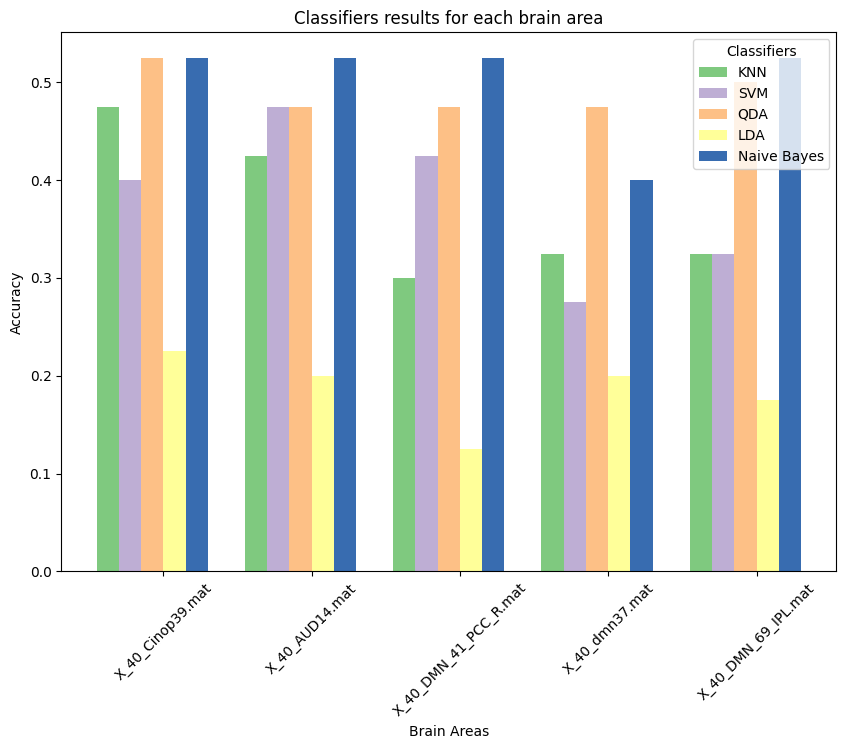

Results for rest time interval: (11, 15)

Results for X_40_Cinop39.mat

    Model Name  AUC Score  Accuracy CV Score  Accuracy Test Score
1          SVM   0.799177            0.37500                0.500
4  Naive Bayes   0.788443            0.48125                0.500
2          QDA   0.732933            0.43750                0.450
0          KNN   0.704318            0.33125                0.525
3          LDA   0.449479            0.20000                0.175

Results for X_40_AUD14.mat

    Model Name  AUC Score  Accuracy CV Score  Accuracy Test Score
2          QDA   0.767985            0.42500                0.550
4  Naive Bayes   0.752095            0.40000                0.375
1          SVM   0.704939            0.35625                0.325
0          KNN   0.697690            0.31250                0.375
3          LDA   0.492659            0.21250                0.125

Results for X_40_DMN_41_PCC_R.mat

    Model Name  AUC Score  Accuracy CV Score  Accuracy Test Score
1    

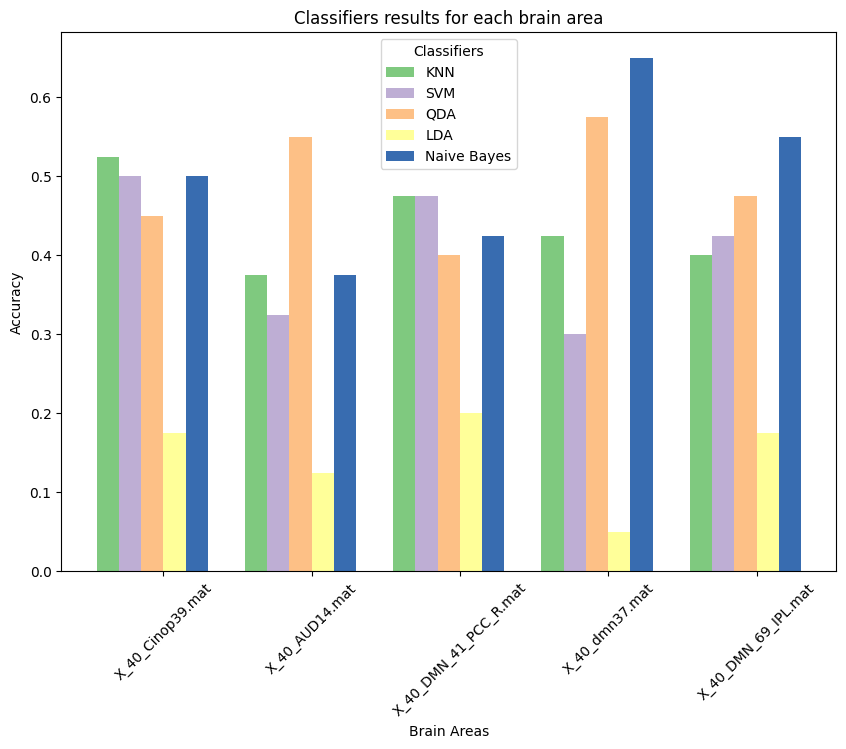

Results for rest time interval: (16, 19)

Results for X_40_Cinop39.mat

    Model Name  AUC Score  Accuracy CV Score  Accuracy Test Score
4  Naive Bayes   0.790844            0.43125                0.500
2          QDA   0.744846            0.40625                0.450
1          SVM   0.654926            0.38750                0.350
0          KNN   0.636680            0.37500                0.450
3          LDA   0.552446            0.22500                0.175

Results for X_40_AUD14.mat

    Model Name  AUC Score  Accuracy CV Score  Accuracy Test Score
4  Naive Bayes   0.825088            0.39375                0.500
2          QDA   0.768805            0.37500                0.525
1          SVM   0.751670            0.35625                0.475
3          LDA   0.698294            0.17500                0.375
0          KNN   0.620268            0.27500                0.350

Results for X_40_DMN_41_PCC_R.mat

    Model Name  AUC Score  Accuracy CV Score  Accuracy Test Score
4  Na

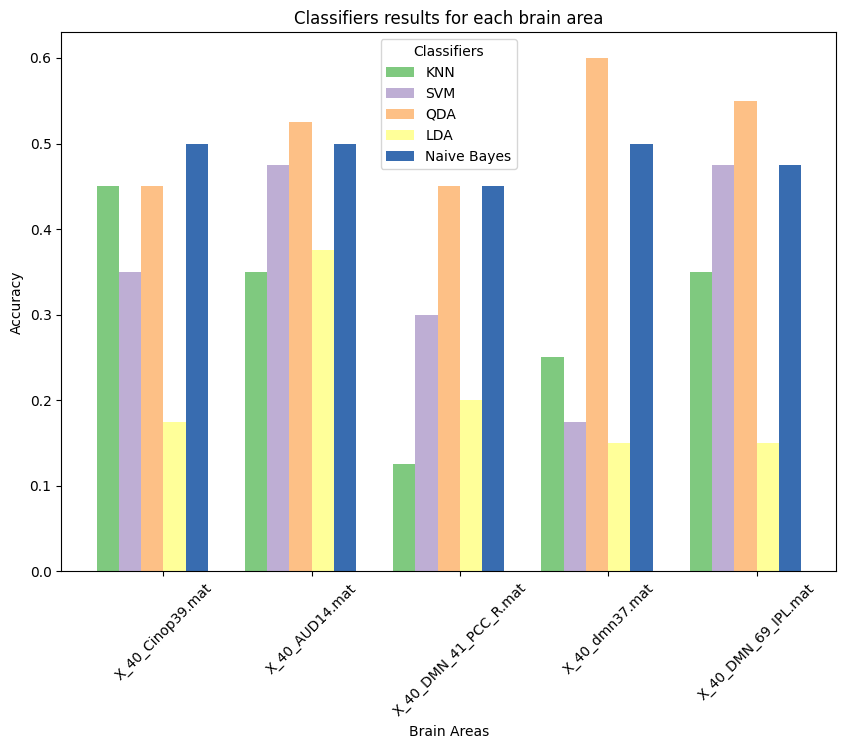

In [ ]:

print("Results in Distance vector method:\n")

for areas_dataset_rest in datasets_subphase:

  print(f"Results for rest time interval: {areas_dataset_rest[0]}")

  # Create a list to store the best model's accuracy score and name from each area
  best_model_accuracies = []

  # Create a list to store the confusion matrices of the best model in each area
  confusion_matrices = []

  # Create a list to store the accuracy scores for each classifier and area
  all_accuracy_scores = []

  # List of classifiers
  classifiers = ['KNN', 'SVM', 'QDA', 'LDA', 'Naive Bayes']

  # Create a list to store the accuracy scores for each classifier in each area
  classifier_accuracy_scores = [[] for _ in range(len(classifiers))]

  # Iterate over the brain areas
  for i in range(len(area_names)):
      # Load data
      df = areas_dataset_rest[1][i][1].copy()

      result_table = pd.DataFrame(columns=['Model Name', 'AUC Score', 'Accuracy CV Score', 'Accuracy Test Score'])

      # Separate features and target
      X = df['feature'].to_list()
      y = df['Output'].astype('int').values

      # Standardize the features
      scaler = StandardScaler()
      X = scaler.fit_transform(X)

      # Split the data into training and testing sets
      X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

      # Define hyperparameters for grid search
      hyperparameters = {
          "KNN": {"n_neighbors": [3, 5, 7, 9, 11]},
          "SVM": {"C": [0.1, 1, 10, 100], "gamma": [1, 0.1, 0.01, 0.001]},
          "QDA": {"reg_param": [0.0, 0.1, 0.2, 0.3, 0.4, 0.5]},
          "LDA": {"solver": ["svd", "lsqr", "eigen"]},
          "Naive Bayes": {}
      }

      # List of models
      models = [
          ("KNN", KNeighborsClassifier()),
          ("SVM", SVC(probability=True)),
          ("QDA", QuadraticDiscriminantAnalysis()),
          ("LDA", LinearDiscriminantAnalysis()),
          ("Naive Bayes",GaussianNB()),
      ]

      # Train and evaluate each model
      model_names = []
      top_models = []

      for name, model in models:
          # Perform grid search to find optimal hyperparameters
          clf = GridSearchCV(model, hyperparameters[name], cv=5)
          clf.fit(X_train, y_train)

          best_model = clf.best_estimator_

          # Apply k-fold Cross Validation
          cv = KFold(n_splits=10, random_state=42, shuffle=True)
          scores = cross_val_score(best_model, X_train, y_train, scoring='accuracy', cv=cv, n_jobs=-1)
          avg_cv_score = np.mean(scores)

          # Predict the labels for the test set
          y_pred = best_model.predict(X_test)

          y_pred_proba = best_model.predict_proba(X_test)
          auc_score = roc_auc_score(y_test, y_pred_proba, multi_class='ovr')

          # Calculate the accuracy on the test set
          test_score = accuracy_score(y_test, y_pred)

          # Store results in the table
          result_table = result_table.append({'Model Name': name,
                                              'AUC Score': auc_score,
                                              'Accuracy CV Score': avg_cv_score,
                                              'Accuracy Test Score': test_score}, ignore_index=True)

          # Store the models and their scores
          top_models.append((name, best_model, avg_cv_score, test_score))
          model_names.append(name)

          # Store the accuracy scores for each classifier in the current area
          classifier_index = classifiers.index(name)
          classifier_accuracy_scores[classifier_index].append(test_score)

      # Sort the result table by AUC score in descending order
      result_table = result_table.sort_values(by='AUC Score', ascending=False)
      # Print the result table
      print(f"\nResults for {area_names[i]}\n")
      print(result_table)


      # Sort models based on their average accuracy score
      top_models.sort(key=lambda x: x[3], reverse=True)

      # Store the best model's accuracy score and name from each area
      best_model_accuracies.append((area_names[i], top_models[0][0], top_models[0][3]))

      # Plot confusion matrix for the best model
      best_model_name, best_model, best_model_cv_score, best_model_test_score = top_models[0]
      y_pred = best_model.predict(X_test)
      cf_matrix = confusion_matrix(y_test, y_pred)

      # Store the confusion matrix of the best model in each area
      confusion_matrices.append((area_names[i], top_models[0][0], cf_matrix))

  # Combine the bar plots into one
  fig, ax = plt.subplots(figsize=(10, 7))
  width = 0.15  # Width of each sub-bar

  for i in range(len(classifiers)):
      x = np.arange(len(area_names))
      color = plt.cm.get_cmap('Accent')(i)  # Generate unique color for each classifier

      # Plotting the sub-bars for each brain area
      ax.bar(x + (i * width), classifier_accuracy_scores[i], width=width, color=color, label=classifiers[i])

  # Setting up the plot labels and legend
  ax.set_xlabel('Brain Areas')
  ax.set_ylabel('Accuracy')
  ax.set_title('Classifiers results for each brain area')
  ax.set_xticks(x + (len(classifiers) / 2 * width))
  ax.set_xticklabels(area_names, rotation = 45)
  ax.legend(title='Classifiers')

  plt.show()

# Conclusions


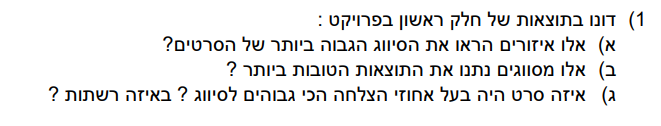


1)

A. The brain areas that show the best movie classification results are:  DMN_69_IPL and Cinop39.

The DMN_69_IPL is involved in functions such as attention and multi-sensory integration, which play crucial roles in processing complex visual and auditory stimuli such as movies.

The CINOP39 is implicated in cognitive control and maintaining attention over tasks.

Given the cognitive demands of discerning between different movies, it's reasonable that these regions, responsible for sensory integration, attention, and cognitive control.

B. We found that the Naive Bayes and LDA models yielded the highest accuracy.
We believe that the performance of the Naive Bayes and LDA models is closely linked to the feature engineering processes we employed: PCA and downsampling. We applied PCA to reduce the dimensionality of our data (becuase the FC matrix presents the connection between voxels).
We continued by creating feature vectors from the FC matrix which, again, represent conectivity between different brain regions during movie watching.

Next, we applied downsampling to further reduce the size of our feature vectors. This helped mitigate the risk of overfitting, particularly relevant for smaller datasets like ours. Given these steps, LDA, which finds a linear combination of features that best separates the different classes, could find a decision boundary effectively.

C. As shown in the Confusion Matrix, the best classifier provided a score of 100% so all the movie's prediction ratio is standing on 100%. From what we see in the Confusion matrix, the two last movies have 100% prediction score for the top 3 areas (DMN_69_IPL, Cinop39, AUD14) shown in Part 1.

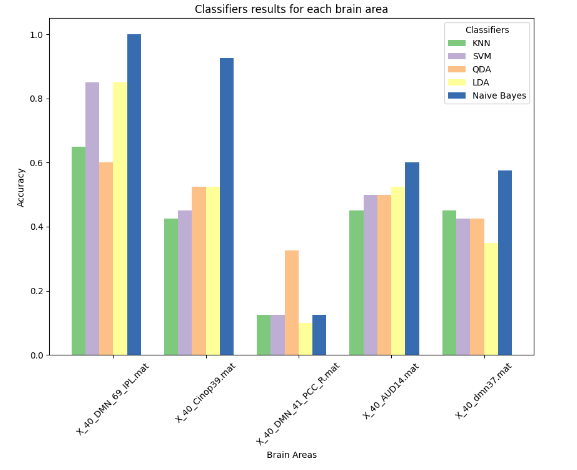

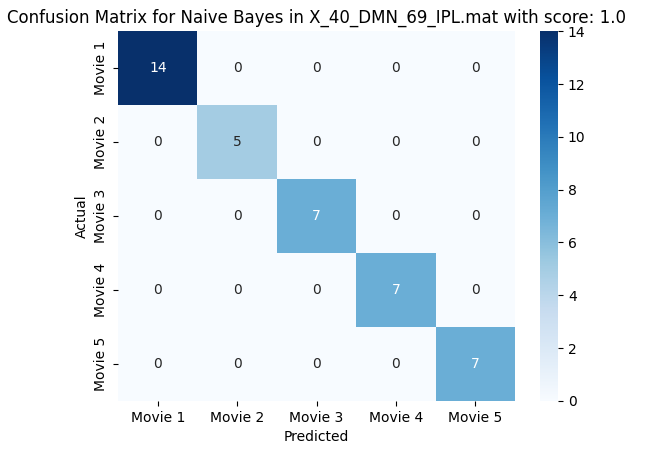

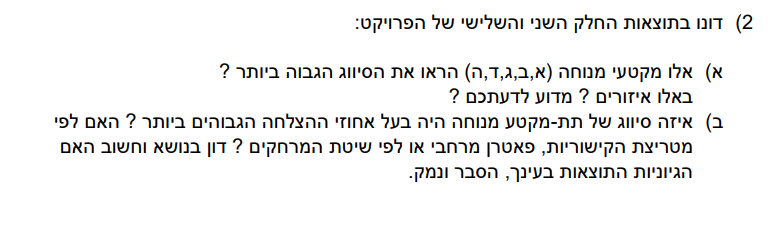

2)

A. The brain areas that show the best resting classification results are:  DMN_69_IPL and Cinop39. The Resting phases that shows the best prediction results are Rest 1, Rest 3 and 5.

As for Rest 1, it was signfically better than the other Resting phases. It might be due to the fact that the subject has only seen one movie until then and still was in the start of the whole test, which makes him more engaged with the process and possibly that can lead to a more consistent brain activity patterns that can be easier to predict.

We assume that the brain signal during the Resting period have some familarities to the signal characteristics during the movie that came before. So, it's very likely that the same areas can be related to the best prediction performance for the resting state.

B. The rest sub-phase with the highest rate of prediction accuracy was TR 11-15, with result of 0.65 from the dmn37 area of the brain. The best result was obtained by the distance vectors method. It seems reasonable because we've seen the same behavior in the previous analysis of Part 3 (Not the bonus), where all of the classifiers performed better with the distance vectors method in comparison to the spatial pattern method.

In addition, the distance vector method seems to work better than the spatial pattern method in our project. Instead of making a single average from a time span, like in the spatial pattern, the distance vector creates individual vectors for each Rest period and then stacks them into a single matrix. This way, the model can learn about how each Rest period relates to the others, and this additional information helps it make better predictions.

* Spatial Pattern method
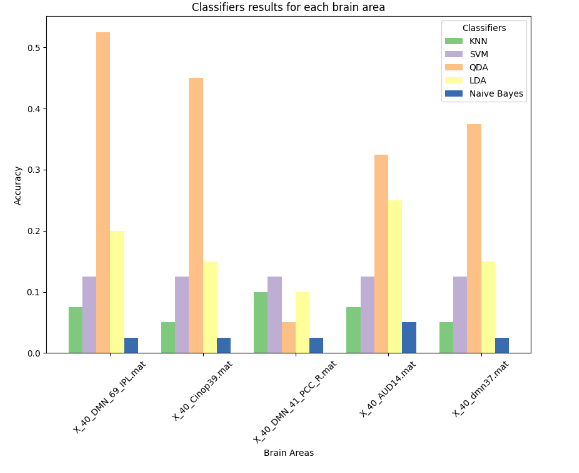

* Spatial Pattern method
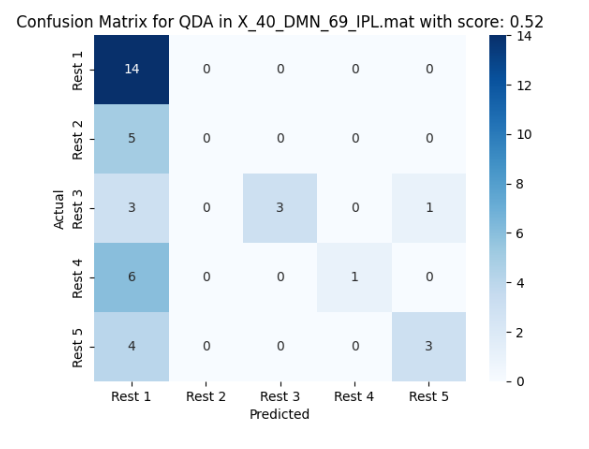

* Distance Vector method
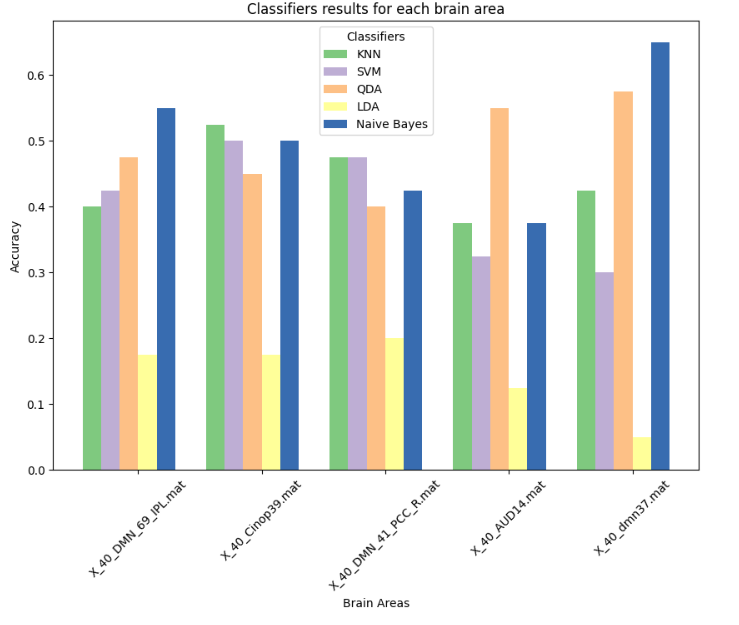

* Distance Vector method
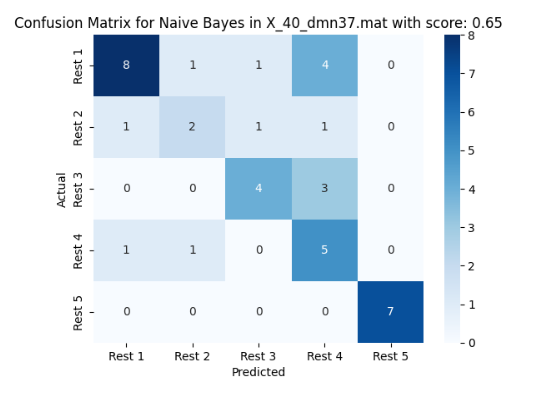